In [1]:
import gc
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset

In [2]:
from source_code.common import (log10, 
                                plot_figure, 
                                plot_slices, 
                                perform_op_over_data, 
                                get_margin_error)
from source_code.network import Network, free_device
from source_code.real_data_experiment import dataset_sampling, get_bounds_mnist

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
GAIN = 0.5
BIAS_VALUE = 0.5
DATA_MODE = 'mnist'

In [5]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight, gain=GAIN)
        m.bias.data.fill_(BIAS_VALUE)

In [6]:
tr_mnist = pd.read_csv('./datasets/mnist_train.csv')
te_mnist = pd.read_csv('./datasets/mnist_train.csv')

In [7]:
tr_mnist['label'] = tr_mnist.label.astype('uint8')
te_mnist['label'] = te_mnist.label.astype('uint8')

# MNIST

In [161]:
# Hyperparams
FLAGS = {
    "batch_size": 16, 
    "input_dim": 784,
    "n_classes" : 10,
    "width" : 1000,
    "depth" : 2,
    "learning_rate" : 0.1,
    "threshold" : 0.03, # Proportion of training points can we ignore
    "margin" : 10, # Margin that needs to be achieved on most of the training points
    "n_test" : 4096,
    "n_train_list" : [512, 1024,2048, 4096, 8192, 16384], # To experiment with larger dataset sizes,
    "seed" : 8312
}

In [162]:
dir_path = './experiment_result/'
sub_dir_path =  dir_path + '{}_gain_{}_bias_{}2/'.format(DATA_MODE, GAIN, BIAS_VALUE)
FLAGS['path'] = sub_dir_path

In [163]:
test_error_path = FLAGS['path'] + 'test_error.png'
test_bound_path = FLAGS['path'] + 'test_error_bound.png'
test_norm_path = FLAGS['path'] + 'test_spectral_norm.png'

In [164]:
os.makedirs(dir_path, exist_ok=True)
os.makedirs(sub_dir_path, exist_ok=True)

In [165]:
init_model_3 = Network(**FLAGS)
init_model_3 = init_model_3.to(device)
torch.cuda.manual_seed(FLAGS['seed'])
torch.manual_seed(FLAGS['seed'])
init_model_3 = init_model_3.apply(init_weights)
initial_weights_3 = list(init_model_3.parameters())
initial_dict_3 = init_model_3.state_dict()
del init_model_3
gc.collect()

18210

In [166]:
# We sample a test set, and multiple independent draws of training sets of varying sizes
test_dataset = dataset_sampling(te_mnist, FLAGS['n_test'], binary=False)

# Note that the function get_random_data is not visible in the blog, but can be found in the notebook after downloading
FLAGS["n_experiments"] = len(FLAGS["n_train_list"])
training_dataset_list = [[] for n_train in FLAGS["n_train_list"]]

for k in range(FLAGS["n_experiments"]):
    training_dataset_list[k] = dataset_sampling(tr_mnist, FLAGS["n_train_list"][k], binary=False)

data shape :  (4096, 785)
data shape :  (512, 785)
data shape :  (1024, 785)
data shape :  (2047, 785)
data shape :  (4096, 785)
data shape :  (8192, 785)
data shape :  (16383, 785)


In [187]:
final_weights_list = [[] for k in range(FLAGS["n_experiments"])] # Weights learned for each dataset size
final_dicts = [[] for k in range(FLAGS["n_experiments"])]
test_errors_list = [0 for k in range(FLAGS["n_experiments"])] # Test error for each dataset size

for k in range(FLAGS["n_experiments"]):
    print(f"\n[INFO] Experiment no. {k + 1} running...")
    
    # Define model
    model_3 = Network(**FLAGS)
    model_3 = model_3.to(device)
    model_3.load_state_dict(initial_dict_3)
    
    # Define criterion and optimizer
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model_3.parameters(), lr=FLAGS["learning_rate"])
    
    # Train
    print(f"[INFO] ...training!")
    epoch = 0
    train_margin_error = 1.0
    
    while train_margin_error > FLAGS["threshold"]:
        epoch += 1
        outs = perform_op_over_data(model_3, training_dataset_list[k],\
                                    criterion, optimizer, device,
                                    batch_size=FLAGS["batch_size"])  
        train_margin_error = get_margin_error(model_3, training_dataset_list[k],\
                                              criterion, optimizer, \
                                              device, batch_size=FLAGS["batch_size"],\
                                              mode=DATA_MODE)
        if  epoch % 10 == 0: 
            print(f"[INFO] [EXP{str(k + 1).zfill(2)}] Epoch {epoch:2d}\n[INFO] [EXP{str(k + 1).zfill(2)}] current margin error: {train_margin_error:.4f}")
        
    # Compute test error
    print(f"[INFO] ...test!\n")
    test_errors_list[k] = get_margin_error(model_3, test_dataset, \
                                           criterion, optimizer,\
                                           device,batch_size=FLAGS['batch_size'],\
                                           mode=DATA_MODE
                                          ) 
    print(f"[INFO] test current margin error: {test_errors_list[k]:.4f}")
    final_weights_list[k] = list(model_3.parameters())
    final_dicts[k] = model_3.state_dict()
    torch.cuda.empty_cache()

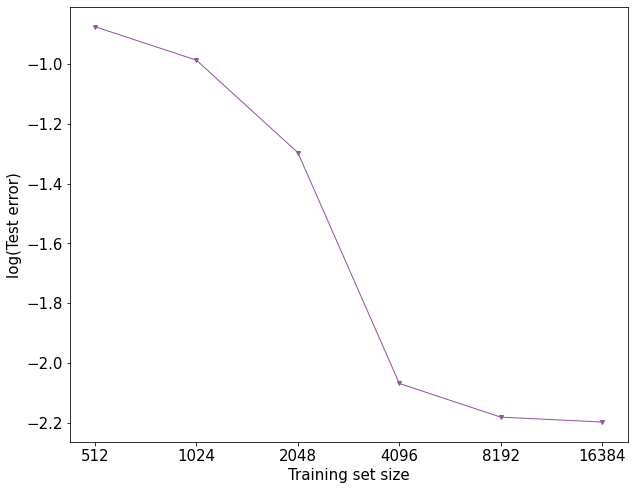

In [169]:
plot_figure("Training set size", "Test error", FLAGS["n_train_list"], 
            test_errors_list, xticks=FLAGS["n_train_list"], save_path=test_error_path)

In [170]:
bounds = [[],[],[]] 

for k in range(FLAGS["n_experiments"]):
    spectral_norms = [np.linalg.norm(w, ord=2) for w in free_device(final_weights_list[k])]
    bound_0, bound_1, bound_2 = get_bounds_mnist(free_device(initial_weights_3), free_device(final_weights_list[k]), \
                                                 spectral_norms, training_dataset_list[k].tensors[0], **FLAGS)
    bounds[0] += [bound_0]
    bounds[1] += [bound_1]
    bounds[2] += [bound_2]

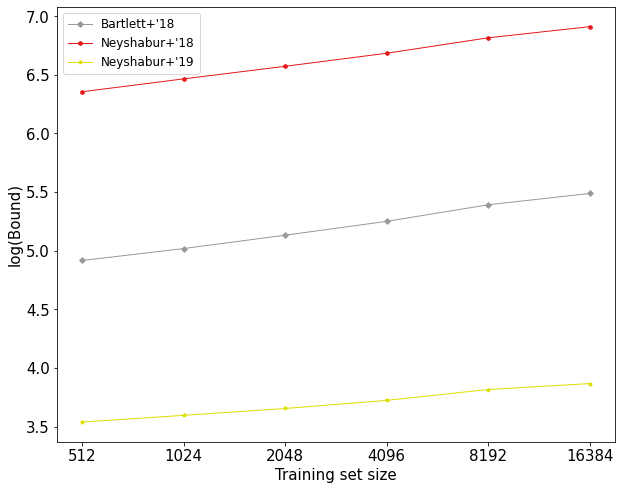

In [171]:
plot_figure("Training set size", "Bound", FLAGS["n_train_list"], bounds, xticks=FLAGS["n_train_list"], 
            save_path=test_bound_path,ylabels=["Bartlett+'18", "Neyshabur+'18", "Neyshabur+'19"])

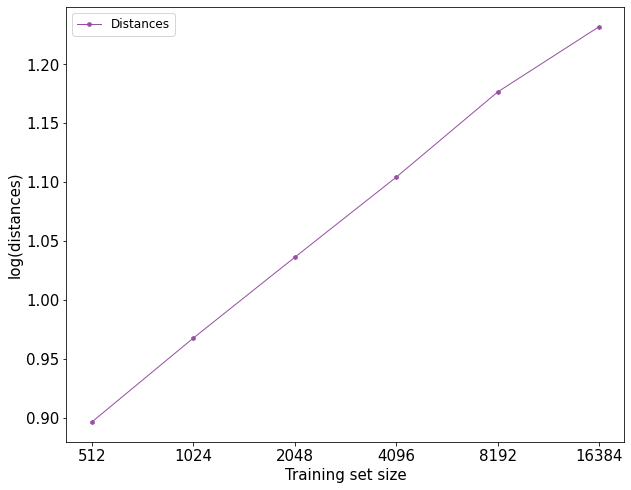

In [179]:
distances = [np.linalg.norm([np.linalg.norm(w[0] - w[1]) for w in zip(free_device(final_weights_list[k]), free_device(initial_weights_3))]) 
             for k in range(FLAGS["n_experiments"])]
plot_figure("Training set size", "distances", FLAGS["n_train_list"],
            [distances],
            xticks=FLAGS["n_train_list"], 
            save_path=test_norm_path,
            ylabels=["Distances"])

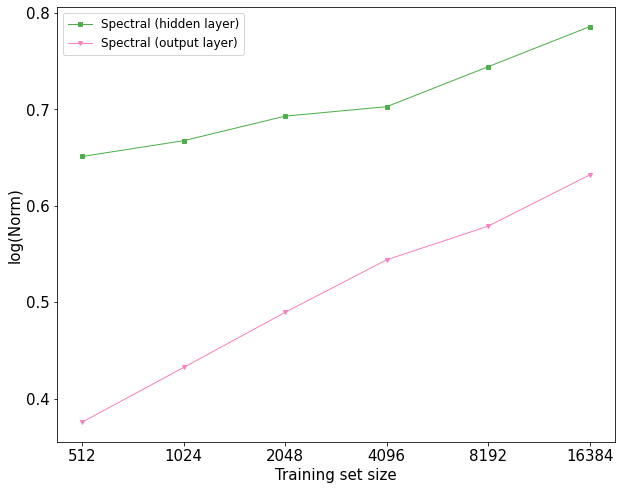

In [177]:

hidden_layer_spectral_norm = [np.linalg.norm(free_device(final_weights_list[k])[0], ord=2) for k in range(FLAGS["n_experiments"])]
output_layer_spectral_norm = [np.linalg.norm(free_device(final_weights_list[k])[2], ord=2) for k in range(FLAGS["n_experiments"])]
plot_figure("Training set size", "Norm", FLAGS["n_train_list"],
            [hidden_layer_spectral_norm, output_layer_spectral_norm],
            xticks=FLAGS["n_train_list"], 
            save_path=test_norm_path,
            ylabels=["Spectral (hidden layer)", "Spectral (output layer)"])

In [45]:
# Hyperparams
FLAGS_2 = {
    "batch_size": [1, 4, 16, 64, 256, 1024], 
    "input_dim": 784,
    "n_classes" : 10,
    "width" : 1000,
    "depth" : 2,
    "learning_rate" : 0.01,
    "threshold" : 0.015, # Proportion of training points can we ignore
    "margin" : 1, # Margin that needs to be achieved on most of the training points
    "n_train" : 8192,
    "n_test" : 4096,
    "seed" : 8312
}

In [46]:
GAIN = 0.5
BIAS_VALUE = 1.0

In [47]:
dir_path = './experiment_result/'
sub_dir_path =  dir_path + '{}_gain_{}_bias_{}_batch5/'.format(DATA_MODE, GAIN, BIAS_VALUE)
FLAGS_2['path'] = sub_dir_path

In [48]:
os.makedirs(dir_path, exist_ok=True)
os.makedirs(sub_dir_path, exist_ok=True)

In [49]:
test_error_path = FLAGS_2['path'] + 'test_error.png'
test_bound_path = FLAGS_2['path'] + 'test_error_bound.png'
test_norm_path = FLAGS_2['path'] + 'test_spectral_norm.png'
test_distance_path = FLAGS_2['path'] + 'test_distance.png'

In [50]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight, gain=GAIN)
        m.bias.data.fill_(BIAS_VALUE)

In [51]:
init_model_4 = Network(**FLAGS_2)
init_model_4 = init_model_4.to(device)
torch.cuda.manual_seed(FLAGS_2['seed'])
torch.manual_seed(FLAGS_2['seed'])
init_model_4 = init_model_4.apply(init_weights)
initial_weights_4 = list(init_model_4.parameters())
initial_dict_4 = init_model_4.state_dict()
del init_model_4
gc.collect()

5688

In [52]:
# We sample a test set, and multiple independent draws of training sets of varying sizes
training_dataset_batch = dataset_sampling(tr_mnist, FLAGS_2["n_train"], binary=False)
test_dataset_batch = dataset_sampling(te_mnist, FLAGS_2['n_test'], binary=False)

# Note that the function get_random_data is not visible in the blog, but can be found in the notebook after downloading
FLAGS_2["n_experiments"] = len(FLAGS_2["batch_size"])

data shape :  (8192, 785)
data shape :  (4096, 785)


In [53]:
from torch.utils.data import DataLoader
from tqdm import tqdm

In [54]:
def perform_op_over_data_batch(model, dataset, criterion, optimizer, device, batch_size, eval=False):
    outs = []
    dataloader = DataLoader(dataset, batch_size=batch_size, pin_memory=True)
    
    if eval:
        model.eval()
    else:
        model.train()
        
    for idx, (inputs, labels) in tqdm(enumerate(dataloader), leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        if eval == False:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        else:
            with torch.no_grad():
                outputs = model(inputs) 
        outs.append(outputs.detach().cpu())
    model_parameters = list(model.parameters())
    return outs, model_parameters

In [57]:
final_weights_list_batch = [[] for k in range(FLAGS_2["n_experiments"])] # Weights learned for each dataset size
# final_dicts_batch = [[] for k in range(FLAGS["n_experiments"])]
test_errors_list_batch = [0 for k in range(FLAGS_2["n_experiments"])] # Test error for each dataset size

for k in range(FLAGS_2["n_experiments"]):
    print(f"\n[INFO] Experiment no. {k + 1} running...")
    
    # Define model
    model_4 = Network(**FLAGS_2)
    model_4 = model_4.to(device)
    model_4.load_state_dict(initial_dict_4)
    
    # Define criterion and optimizer
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model_4.parameters(), lr=FLAGS_2["learning_rate"])
    
    # Train
    print(f"[INFO] ...training! batch_size : ", str(FLAGS_2["batch_size"][k]))
    epoch = 0
    train_margin_error = 1.0
    
    while train_margin_error > FLAGS_2["threshold"]:
        epoch += 1
        outs, model_parameters = perform_op_over_data_batch(model_4, training_dataset_batch,\
                                        criterion, optimizer, device,
                                        batch_size=FLAGS_2["batch_size"][k])  
        train_margin_error = get_margin_error(model_4, training_dataset_batch,\
                                              criterion, optimizer, \
                                              device, batch_size=FLAGS_2["batch_size"][k],\
                                              mode=DATA_MODE)
        if  epoch % 10 == 0: 
            print(f"[INFO] [EXP{str(k + 1).zfill(2)}] Epoch {epoch:2d}\n[INFO] [EXP{str(k + 1).zfill(2)}] current margin error: {train_margin_error:.4f}")
        
    # Compute test error
    print(f"[INFO] ...test!\n")
    test_errors_list_batch[k] = get_margin_error(model_4, test_dataset_batch, \
                                           criterion, optimizer,\
                                           device,batch_size=FLAGS_2['batch_size'][k],\
                                           mode=DATA_MODE
                                          ) 
    print(f"[INFO] test current margin error: {test_errors_list_batch[k]:.4f}")
    final_weights_list_batch[k] = model_parameters
#     final_dicts_batch[k] = model_4.state_dict()
    torch.cuda.empty_cache()

80it [00:00, 792.40it/s]


[INFO] Experiment no. 1 running...
[INFO] ...training! batch_size :  1


117it [00:00, 1162.62it/s] 

multi-output


138it [00:00, 1370.51it/s] 

multi-output


128it [00:00, 1279.03it/s] 

multi-output


114it [00:00, 1137.59it/s] 

multi-output


106it [00:00, 1056.33it/s] 

multi-output


362it [00:00, 3615.09it/s] 

multi-output
[INFO] ...test!



139it [00:00, 1383.10it/s] 

multi-output
[INFO] test current margin error: 0.0112

[INFO] Experiment no. 2 running...
[INFO] ...training! batch_size :  4


129it [00:00, 1281.29it/s] 

multi-output


0it [00:00, ?it/s]         

multi-output


115it [00:00, 1146.13it/s] 

multi-output


115it [00:00, 1143.27it/s] 

multi-output


109it [00:00, 1089.07it/s] 

multi-output


120it [00:00, 1198.09it/s] 

multi-output


139it [00:00, 1383.76it/s] 

multi-output


120it [00:00, 1197.99it/s] 

multi-output


128it [00:00, 1279.64it/s] 

multi-output


119it [00:00, 1188.55it/s] 

multi-output
[INFO] [EXP02] Epoch 10
[INFO] [EXP02] current margin error: 0.0447


109it [00:00, 1083.31it/s] 

multi-output


114it [00:00, 1134.52it/s] 

multi-output


115it [00:00, 1142.65it/s] 

multi-output


124it [00:00, 1231.82it/s] 

multi-output


114it [00:00, 1139.59it/s] 

multi-output


124it [00:00, 1237.83it/s] 

multi-output


0it [00:00, ?it/s]         

multi-output


111it [00:00, 1107.43it/s] 

multi-output


124it [00:00, 1236.44it/s] 

multi-output


322it [00:00, 3213.10it/s] 

multi-output
[INFO] [EXP02] Epoch 20
[INFO] [EXP02] current margin error: 0.0135
[INFO] ...test!



123it [00:00, 1226.43it/s]

multi-output
[INFO] test current margin error: 0.0132

[INFO] Experiment no. 3 running...
[INFO] ...training! batch_size :  16


126it [00:00, 1259.07it/s]

multi-output


125it [00:00, 1243.70it/s]

multi-output


126it [00:00, 1252.16it/s]

multi-output


126it [00:00, 1251.82it/s]

multi-output


126it [00:00, 1251.49it/s]

multi-output


114it [00:00, 1133.66it/s]

multi-output


0it [00:00, ?it/s]        

multi-output


115it [00:00, 1146.95it/s]

multi-output


114it [00:00, 1135.30it/s]

multi-output


105it [00:00, 1049.46it/s]

multi-output
[INFO] [EXP03] Epoch 10
[INFO] [EXP03] current margin error: 0.0891


125it [00:00, 1247.05it/s]

multi-output


124it [00:00, 1238.21it/s]

multi-output


125it [00:00, 1249.23it/s]

multi-output


125it [00:00, 1247.48it/s]

multi-output


125it [00:00, 1247.15it/s]

multi-output


122it [00:00, 1212.76it/s]

multi-output


125it [00:00, 1240.84it/s]

multi-output


0it [00:00, ?it/s]        

multi-output


124it [00:00, 1237.85it/s]

multi-output


126it [00:00, 1259.63it/s]

multi-output
[INFO] [EXP03] Epoch 20
[INFO] [EXP03] current margin error: 0.0751


126it [00:00, 1259.61it/s]

multi-output


124it [00:00, 1239.51it/s]

multi-output


127it [00:00, 1265.29it/s]

multi-output


126it [00:00, 1256.39it/s]

multi-output


125it [00:00, 1249.16it/s]

multi-output


127it [00:00, 1266.69it/s]

multi-output


127it [00:00, 1260.89it/s]

multi-output


127it [00:00, 1261.57it/s]

multi-output


126it [00:00, 1253.16it/s]

multi-output


0it [00:00, ?it/s]        

multi-output
[INFO] [EXP03] Epoch 30
[INFO] [EXP03] current margin error: 0.0658


126it [00:00, 1256.25it/s]

multi-output


125it [00:00, 1243.93it/s]

multi-output


126it [00:00, 1253.83it/s]

multi-output


126it [00:00, 1256.14it/s]

multi-output


127it [00:00, 1261.22it/s]

multi-output


127it [00:00, 1267.98it/s]

multi-output


126it [00:00, 1255.25it/s]

multi-output


128it [00:00, 1270.17it/s]

multi-output


127it [00:00, 1269.72it/s]

multi-output


127it [00:00, 1261.44it/s]

multi-output
[INFO] [EXP03] Epoch 40
[INFO] [EXP03] current margin error: 0.0568


127it [00:00, 1264.49it/s]

multi-output


0it [00:00, ?it/s]        

multi-output


127it [00:00, 1264.73it/s]

multi-output


127it [00:00, 1265.32it/s]

multi-output


127it [00:00, 1265.20it/s]

multi-output


125it [00:00, 1244.38it/s]

multi-output


126it [00:00, 1251.26it/s]

multi-output


126it [00:00, 1253.00it/s]

multi-output


126it [00:00, 1254.60it/s]

multi-output


127it [00:00, 1264.12it/s]

multi-output
[INFO] [EXP03] Epoch 50
[INFO] [EXP03] current margin error: 0.0482


127it [00:00, 1267.73it/s]

multi-output


126it [00:00, 1258.49it/s]

multi-output


128it [00:00, 1271.63it/s]

multi-output


0it [00:00, ?it/s]        

multi-output


126it [00:00, 1253.09it/s]

multi-output


127it [00:00, 1268.99it/s]

multi-output


127it [00:00, 1268.01it/s]

multi-output


127it [00:00, 1268.20it/s]

multi-output


128it [00:00, 1270.03it/s]

multi-output


128it [00:00, 1271.65it/s]

multi-output
[INFO] [EXP03] Epoch 60
[INFO] [EXP03] current margin error: 0.0398


128it [00:00, 1270.59it/s]

multi-output


128it [00:00, 1270.89it/s]

multi-output


128it [00:00, 1273.52it/s]

multi-output


127it [00:00, 1261.99it/s]

multi-output


0it [00:00, ?it/s]        

multi-output


127it [00:00, 1265.39it/s]

multi-output


126it [00:00, 1259.47it/s]

multi-output


127it [00:00, 1268.06it/s]

multi-output


126it [00:00, 1258.49it/s]

multi-output


122it [00:00, 1218.32it/s]

multi-output
[INFO] [EXP03] Epoch 70
[INFO] [EXP03] current margin error: 0.0320


124it [00:00, 1235.00it/s]

multi-output


127it [00:00, 1268.48it/s]

multi-output


127it [00:00, 1265.69it/s]

multi-output


127it [00:00, 1268.12it/s]

multi-output


127it [00:00, 1262.94it/s]

multi-output


127it [00:00, 1266.95it/s]

multi-output


0it [00:00, ?it/s]        

multi-output


127it [00:00, 1265.52it/s]

multi-output


127it [00:00, 1262.86it/s]

multi-output


127it [00:00, 1264.66it/s]

multi-output
[INFO] [EXP03] Epoch 80
[INFO] [EXP03] current margin error: 0.0245


125it [00:00, 1244.07it/s]

multi-output


127it [00:00, 1261.47it/s]

multi-output


128it [00:00, 1270.77it/s]

multi-output


112it [00:00, 1114.72it/s]

multi-output


128it [00:00, 1274.63it/s]

multi-output


127it [00:00, 1260.40it/s]

multi-output


122it [00:00, 1214.85it/s]

multi-output


126it [00:00, 1256.83it/s]

multi-output


0it [00:00, ?it/s]        

multi-output


125it [00:00, 1248.18it/s]

multi-output
[INFO] [EXP03] Epoch 90
[INFO] [EXP03] current margin error: 0.0184


126it [00:00, 1256.19it/s]

multi-output


127it [00:00, 1262.67it/s]

multi-output


126it [00:00, 1257.80it/s]

multi-output


126it [00:00, 1254.81it/s]

multi-output


126it [00:00, 1250.70it/s]

multi-output


multi-output
[INFO] ...test!

multi-output
[INFO] test current margin error: 0.0144

[INFO] Experiment no. 4 running...


0it [00:00, ?it/s]      

[INFO] ...training! batch_size :  64


87it [00:00, 867.02it/s]

multi-output


88it [00:00, 872.59it/s]

multi-output


88it [00:00, 873.25it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


88it [00:00, 875.33it/s]

multi-output


88it [00:00, 873.40it/s]

multi-output


88it [00:00, 875.38it/s]

multi-output


88it [00:00, 874.78it/s]

multi-output


88it [00:00, 873.99it/s]

multi-output


88it [00:00, 875.91it/s]

multi-output
[INFO] [EXP04] Epoch 10
[INFO] [EXP04] current margin error: 0.1178


88it [00:00, 872.65it/s]

multi-output


88it [00:00, 874.11it/s]

multi-output


88it [00:00, 873.56it/s]

multi-output


87it [00:00, 865.39it/s]

multi-output


88it [00:00, 872.80it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


88it [00:00, 870.50it/s]

multi-output


88it [00:00, 871.10it/s]

multi-output


87it [00:00, 861.52it/s]

multi-output


70it [00:00, 699.40it/s]

multi-output
[INFO] [EXP04] Epoch 20
[INFO] [EXP04] current margin error: 0.1008


71it [00:00, 701.51it/s]  

multi-output


71it [00:00, 706.40it/s]  

multi-output


71it [00:00, 704.06it/s]  

multi-output


71it [00:00, 705.79it/s]  

multi-output


71it [00:00, 706.91it/s]  

multi-output


70it [00:00, 699.15it/s]  

multi-output


71it [00:00, 705.88it/s]  

multi-output


0it [00:00, ?it/s]        

multi-output


70it [00:00, 697.73it/s]

multi-output


69it [00:00, 687.04it/s]  

multi-output
[INFO] [EXP04] Epoch 30
[INFO] [EXP04] current margin error: 0.0939


70it [00:00, 693.27it/s]  

multi-output


70it [00:00, 693.75it/s]  

multi-output


70it [00:00, 694.39it/s]  

multi-output


80it [00:00, 799.40it/s]

multi-output


81it [00:00, 800.98it/s]

multi-output


80it [00:00, 797.96it/s]

multi-output


79it [00:00, 788.49it/s]

multi-output


80it [00:00, 799.19it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


81it [00:00, 808.86it/s]

multi-output
[INFO] [EXP04] Epoch 40
[INFO] [EXP04] current margin error: 0.0878


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]      

multi-output


85it [00:00, 845.59it/s]

multi-output


85it [00:00, 846.45it/s]

multi-output


85it [00:00, 846.26it/s]

multi-output


85it [00:00, 846.07it/s]

multi-output


85it [00:00, 847.33it/s]

multi-output


85it [00:00, 845.24it/s]

multi-output


85it [00:00, 847.33it/s]

multi-output
[INFO] [EXP04] Epoch 50
[INFO] [EXP04] current margin error: 0.0839


0it [00:00, ?it/s]      

multi-output


80it [00:00, 796.24it/s]

multi-output


80it [00:00, 797.43it/s]

multi-output


80it [00:00, 797.01it/s]

multi-output


0it [00:00, ?it/s]        

multi-output


0it [00:00, ?it/s]        

multi-output


0it [00:00, ?it/s]        

multi-output


87it [00:00, 867.57it/s]

multi-output


78it [00:00, 771.28it/s]

multi-output


78it [00:00, 769.94it/s]

multi-output
[INFO] [EXP04] Epoch 60
[INFO] [EXP04] current margin error: 0.0801


84it [00:00, 835.61it/s]

multi-output


85it [00:00, 841.06it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


84it [00:00, 831.71it/s]

multi-output


84it [00:00, 839.04it/s]

multi-output


85it [00:00, 840.38it/s]

multi-output


88it [00:00, 875.52it/s]

multi-output


84it [00:00, 838.63it/s]

multi-output


80it [00:00, 797.49it/s]

multi-output


85it [00:00, 839.81it/s]

multi-output
[INFO] [EXP04] Epoch 70
[INFO] [EXP04] current margin error: 0.0771


85it [00:00, 839.93it/s]

multi-output


85it [00:00, 843.46it/s]

multi-output


84it [00:00, 838.95it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


84it [00:00, 832.16it/s]

multi-output


84it [00:00, 831.94it/s]

multi-output


83it [00:00, 826.54it/s]

multi-output


84it [00:00, 833.73it/s]

multi-output


84it [00:00, 836.13it/s]

multi-output


84it [00:00, 839.24it/s]

multi-output
[INFO] [EXP04] Epoch 80
[INFO] [EXP04] current margin error: 0.0743


85it [00:00, 840.58it/s]

multi-output


84it [00:00, 837.30it/s]

multi-output


86it [00:00, 858.34it/s]

multi-output


87it [00:00, 867.97it/s]

multi-output


88it [00:00, 877.33it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


88it [00:00, 873.91it/s]

multi-output


88it [00:00, 875.78it/s]

multi-output


88it [00:00, 875.72it/s]

multi-output


88it [00:00, 878.19it/s]

multi-output
[INFO] [EXP04] Epoch 90
[INFO] [EXP04] current margin error: 0.0732


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]      

multi-output


87it [00:00, 866.27it/s]

multi-output


87it [00:00, 861.41it/s]

multi-output


88it [00:00, 877.62it/s]

multi-output


85it [00:00, 842.84it/s]

multi-output


83it [00:00, 827.76it/s]

multi-output


85it [00:00, 843.80it/s]

multi-output


83it [00:00, 823.16it/s]

multi-output


82it [00:00, 814.29it/s]

multi-output
[INFO] [EXP04] Epoch 100
[INFO] [EXP04] current margin error: 0.0703


82it [00:00, 815.22it/s]

multi-output


82it [00:00, 816.36it/s]

multi-output


82it [00:00, 814.89it/s]

multi-output


82it [00:00, 815.91it/s]

multi-output


79it [00:00, 781.08it/s]

multi-output


81it [00:00, 803.23it/s]

multi-output


85it [00:00, 847.53it/s]

multi-output


81it [00:00, 806.12it/s]

multi-output


82it [00:00, 813.80it/s]

multi-output


79it [00:00, 786.46it/s]

multi-output
[INFO] [EXP04] Epoch 110
[INFO] [EXP04] current margin error: 0.0681


80it [00:00, 797.49it/s]

multi-output


87it [00:00, 866.14it/s]

multi-output


75it [00:00, 742.45it/s]

multi-output


80it [00:00, 795.82it/s]

multi-output


77it [00:00, 762.22it/s]

multi-output


82it [00:00, 812.74it/s]

multi-output


80it [00:00, 792.91it/s]

multi-output


80it [00:00, 798.33it/s]

multi-output


80it [00:00, 799.61it/s]

multi-output


80it [00:00, 798.90it/s]

multi-output
[INFO] [EXP04] Epoch 120
[INFO] [EXP04] current margin error: 0.0662


80it [00:00, 799.44it/s]

multi-output


79it [00:00, 789.19it/s]

multi-output


80it [00:00, 793.43it/s]

multi-output


80it [00:00, 789.97it/s]

multi-output


80it [00:00, 790.46it/s]

multi-output


81it [00:00, 800.58it/s]

multi-output


81it [00:00, 800.94it/s]

multi-output


80it [00:00, 798.40it/s]

multi-output


80it [00:00, 797.75it/s]

multi-output


80it [00:00, 793.81it/s]

multi-output
[INFO] [EXP04] Epoch 130
[INFO] [EXP04] current margin error: 0.0636


79it [00:00, 788.23it/s]

multi-output


80it [00:00, 791.10it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


80it [00:00, 792.97it/s]

multi-output


79it [00:00, 789.66it/s]

multi-output


80it [00:00, 792.92it/s]

multi-output


80it [00:00, 790.77it/s]

multi-output


79it [00:00, 788.14it/s]

multi-output


79it [00:00, 789.05it/s]

multi-output


79it [00:00, 784.30it/s]

multi-output
[INFO] [EXP04] Epoch 140
[INFO] [EXP04] current margin error: 0.0615


77it [00:00, 769.51it/s]

multi-output


83it [00:00, 820.63it/s]

multi-output


84it [00:00, 836.21it/s]

multi-output


87it [00:00, 861.78it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


87it [00:00, 868.84it/s]

multi-output


88it [00:00, 871.36it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


83it [00:00, 825.22it/s]

multi-output


76it [00:00, 754.35it/s]

multi-output
[INFO] [EXP04] Epoch 150
[INFO] [EXP04] current margin error: 0.0601


85it [00:00, 841.91it/s]

multi-output


85it [00:00, 843.32it/s]

multi-output


85it [00:00, 840.83it/s]

multi-output


84it [00:00, 834.95it/s]

multi-output


84it [00:00, 838.34it/s]

multi-output


84it [00:00, 833.92it/s]

multi-output


84it [00:00, 833.61it/s]

multi-output


84it [00:00, 838.01it/s]

multi-output


77it [00:00, 767.18it/s]

multi-output


84it [00:00, 836.22it/s]

multi-output
[INFO] [EXP04] Epoch 160
[INFO] [EXP04] current margin error: 0.0585


88it [00:00, 872.62it/s]

multi-output


88it [00:00, 874.32it/s]

multi-output


85it [00:00, 842.72it/s]

multi-output


84it [00:00, 835.78it/s]

multi-output


84it [00:00, 839.30it/s]

multi-output


85it [00:00, 839.74it/s]

multi-output


85it [00:00, 843.46it/s]

multi-output


83it [00:00, 828.67it/s]

multi-output


85it [00:00, 845.41it/s]

multi-output


0it [00:00, ?it/s]      

multi-output
[INFO] [EXP04] Epoch 170
[INFO] [EXP04] current margin error: 0.0570


79it [00:00, 786.27it/s]  

multi-output


0it [00:00, ?it/s]      

multi-output


81it [00:00, 808.76it/s]

multi-output


80it [00:00, 791.24it/s]

multi-output


80it [00:00, 790.15it/s]

multi-output


80it [00:00, 791.44it/s]

multi-output


80it [00:00, 791.82it/s]

multi-output


80it [00:00, 790.05it/s]

multi-output


80it [00:00, 791.85it/s]

multi-output


79it [00:00, 783.24it/s]

multi-output
[INFO] [EXP04] Epoch 180
[INFO] [EXP04] current margin error: 0.0542


79it [00:00, 787.83it/s]

multi-output


78it [00:00, 770.42it/s]

multi-output


85it [00:00, 845.89it/s]

multi-output


84it [00:00, 833.48it/s]

multi-output


86it [00:00, 855.22it/s]

multi-output


80it [00:00, 798.84it/s]

multi-output


87it [00:00, 864.03it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


85it [00:00, 843.49it/s]

multi-output


85it [00:00, 843.24it/s]

multi-output
[INFO] [EXP04] Epoch 190
[INFO] [EXP04] current margin error: 0.0526


85it [00:00, 842.59it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


85it [00:00, 842.63it/s]

multi-output


85it [00:00, 843.07it/s]

multi-output


84it [00:00, 837.89it/s]

multi-output


85it [00:00, 844.36it/s]

multi-output


85it [00:00, 842.82it/s]

multi-output


85it [00:00, 842.25it/s]

multi-output


85it [00:00, 846.43it/s]

multi-output


80it [00:00, 790.76it/s]

multi-output
[INFO] [EXP04] Epoch 200
[INFO] [EXP04] current margin error: 0.0514


85it [00:00, 840.53it/s]

multi-output


84it [00:00, 833.41it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


87it [00:00, 865.95it/s]

multi-output


87it [00:00, 865.02it/s]

multi-output


80it [00:00, 797.63it/s]

multi-output


85it [00:00, 843.25it/s]

multi-output


85it [00:00, 844.59it/s]

multi-output


85it [00:00, 844.65it/s]

multi-output


85it [00:00, 843.17it/s]

multi-output
[INFO] [EXP04] Epoch 210
[INFO] [EXP04] current margin error: 0.0496


81it [00:00, 808.43it/s]

multi-output


85it [00:00, 840.68it/s]

multi-output


83it [00:00, 828.55it/s]

multi-output


85it [00:00, 842.59it/s]

multi-output


83it [00:00, 826.11it/s]

multi-output


85it [00:00, 842.62it/s]

multi-output


85it [00:00, 844.08it/s]

multi-output


85it [00:00, 843.21it/s]

multi-output


85it [00:00, 840.32it/s]

multi-output


85it [00:00, 842.77it/s]

multi-output
[INFO] [EXP04] Epoch 220
[INFO] [EXP04] current margin error: 0.0480


81it [00:00, 808.34it/s]

multi-output


85it [00:00, 842.42it/s]

multi-output


84it [00:00, 835.14it/s]

multi-output


85it [00:00, 842.23it/s]

multi-output


85it [00:00, 841.10it/s]

multi-output


87it [00:00, 867.34it/s]

multi-output


82it [00:00, 816.99it/s]

multi-output


87it [00:00, 863.10it/s]

multi-output


87it [00:00, 862.50it/s]

multi-output


86it [00:00, 858.51it/s]

multi-output
[INFO] [EXP04] Epoch 230
[INFO] [EXP04] current margin error: 0.0463


0it [00:00, ?it/s]      

multi-output


84it [00:00, 835.71it/s]

multi-output


85it [00:00, 844.70it/s]

multi-output


85it [00:00, 845.74it/s]

multi-output


84it [00:00, 836.44it/s]

multi-output


85it [00:00, 842.95it/s]

multi-output


85it [00:00, 846.11it/s]

multi-output


85it [00:00, 844.52it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]      

multi-output
[INFO] [EXP04] Epoch 240
[INFO] [EXP04] current margin error: 0.0437


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]      

multi-output


86it [00:00, 856.51it/s]

multi-output


85it [00:00, 842.62it/s]

multi-output


87it [00:00, 862.91it/s]

multi-output


83it [00:00, 824.30it/s]

multi-output


85it [00:00, 841.48it/s]

multi-output


84it [00:00, 839.90it/s]

multi-output


85it [00:00, 842.21it/s]

multi-output


0it [00:00, ?it/s]      

multi-output
[INFO] [EXP04] Epoch 250
[INFO] [EXP04] current margin error: 0.0419


84it [00:00, 838.99it/s]

multi-output


85it [00:00, 843.17it/s]

multi-output


84it [00:00, 831.63it/s]

multi-output


81it [00:00, 802.17it/s]

multi-output


83it [00:00, 820.30it/s]

multi-output


78it [00:00, 779.71it/s]

multi-output


85it [00:00, 841.62it/s]

multi-output


85it [00:00, 844.35it/s]

multi-output


85it [00:00, 840.73it/s]

multi-output


83it [00:00, 824.47it/s]

multi-output
[INFO] [EXP04] Epoch 260
[INFO] [EXP04] current margin error: 0.0402


81it [00:00, 801.87it/s]

multi-output


86it [00:00, 858.18it/s]

multi-output


85it [00:00, 841.66it/s]

multi-output


82it [00:00, 817.84it/s]

multi-output


84it [00:00, 834.40it/s]

multi-output


83it [00:00, 827.53it/s]

multi-output


85it [00:00, 843.22it/s]

multi-output


85it [00:00, 840.94it/s]

multi-output


85it [00:00, 844.11it/s]

multi-output


85it [00:00, 842.91it/s]

multi-output
[INFO] [EXP04] Epoch 270
[INFO] [EXP04] current margin error: 0.0391


78it [00:00, 773.83it/s]

multi-output


79it [00:00, 789.26it/s]

multi-output


79it [00:00, 784.72it/s]

multi-output


78it [00:00, 776.56it/s]

multi-output


79it [00:00, 785.23it/s]

multi-output


79it [00:00, 780.07it/s]

multi-output


79it [00:00, 785.95it/s]

multi-output


79it [00:00, 784.68it/s]

multi-output


79it [00:00, 784.69it/s]

multi-output


79it [00:00, 785.56it/s]

multi-output
[INFO] [EXP04] Epoch 280
[INFO] [EXP04] current margin error: 0.0369


79it [00:00, 788.06it/s]

multi-output


79it [00:00, 786.20it/s]

multi-output


79it [00:00, 785.22it/s]

multi-output


79it [00:00, 787.14it/s]

multi-output


79it [00:00, 787.52it/s]

multi-output


79it [00:00, 780.51it/s]

multi-output


79it [00:00, 785.02it/s]

multi-output


79it [00:00, 783.07it/s]

multi-output


77it [00:00, 766.00it/s]

multi-output


82it [00:00, 810.64it/s]

multi-output
[INFO] [EXP04] Epoch 290
[INFO] [EXP04] current margin error: 0.0347


85it [00:00, 842.35it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


81it [00:00, 806.35it/s]

multi-output


80it [00:00, 790.42it/s]

multi-output


79it [00:00, 783.51it/s]

multi-output


84it [00:00, 834.17it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


84it [00:00, 833.90it/s]

multi-output


84it [00:00, 834.60it/s]

multi-output


84it [00:00, 834.44it/s]

multi-output
[INFO] [EXP04] Epoch 300
[INFO] [EXP04] current margin error: 0.0323


85it [00:00, 842.81it/s]

multi-output


85it [00:00, 843.62it/s]

multi-output


81it [00:00, 805.04it/s]

multi-output


83it [00:00, 816.13it/s]

multi-output


84it [00:00, 838.11it/s]

multi-output


84it [00:00, 836.79it/s]

multi-output


79it [00:00, 781.19it/s]

multi-output


88it [00:00, 870.55it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


83it [00:00, 825.78it/s]

multi-output
[INFO] [EXP04] Epoch 310
[INFO] [EXP04] current margin error: 0.0310


85it [00:00, 840.28it/s]

multi-output


84it [00:00, 837.36it/s]

multi-output


79it [00:00, 784.62it/s]

multi-output


79it [00:00, 786.23it/s]

multi-output


79it [00:00, 788.72it/s]

multi-output


79it [00:00, 783.43it/s]

multi-output


79it [00:00, 786.01it/s]

multi-output


80it [00:00, 792.67it/s]

multi-output


82it [00:00, 813.37it/s]

multi-output


84it [00:00, 830.35it/s]

multi-output
[INFO] [EXP04] Epoch 320
[INFO] [EXP04] current margin error: 0.0295


84it [00:00, 830.49it/s]

multi-output


84it [00:00, 838.11it/s]

multi-output


84it [00:00, 836.91it/s]

multi-output


84it [00:00, 839.70it/s]

multi-output


84it [00:00, 835.62it/s]

multi-output


87it [00:00, 861.37it/s]

multi-output


86it [00:00, 858.92it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]      

multi-output
[INFO] [EXP04] Epoch 330
[INFO] [EXP04] current margin error: 0.0284


85it [00:00, 845.00it/s]

multi-output


84it [00:00, 835.75it/s]

multi-output


85it [00:00, 843.06it/s]

multi-output


84it [00:00, 838.79it/s]

multi-output


85it [00:00, 841.35it/s]

multi-output


84it [00:00, 839.92it/s]

multi-output


85it [00:00, 840.99it/s]

multi-output


81it [00:00, 808.19it/s]

multi-output


85it [00:00, 842.26it/s]

multi-output


84it [00:00, 838.69it/s]

multi-output
[INFO] [EXP04] Epoch 340
[INFO] [EXP04] current margin error: 0.0277


85it [00:00, 843.87it/s]

multi-output


85it [00:00, 840.81it/s]

multi-output


85it [00:00, 839.85it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


85it [00:00, 842.84it/s]

multi-output


85it [00:00, 843.83it/s]

multi-output


84it [00:00, 839.34it/s]

multi-output


85it [00:00, 843.89it/s]

multi-output


85it [00:00, 845.26it/s]

multi-output


85it [00:00, 840.88it/s]

multi-output
[INFO] [EXP04] Epoch 350
[INFO] [EXP04] current margin error: 0.0260


85it [00:00, 846.42it/s]

multi-output


85it [00:00, 841.41it/s]

multi-output


85it [00:00, 843.96it/s]

multi-output


85it [00:00, 843.87it/s]

multi-output


85it [00:00, 843.90it/s]

multi-output


84it [00:00, 834.23it/s]

multi-output


85it [00:00, 844.51it/s]

multi-output


85it [00:00, 841.25it/s]

multi-output


84it [00:00, 836.96it/s]

multi-output


85it [00:00, 840.63it/s]

multi-output
[INFO] [EXP04] Epoch 360
[INFO] [EXP04] current margin error: 0.0249


84it [00:00, 833.19it/s]

multi-output


85it [00:00, 843.61it/s]

multi-output


85it [00:00, 841.71it/s]

multi-output


83it [00:00, 827.24it/s]

multi-output


87it [00:00, 863.85it/s]

multi-output


0it [00:00, ?it/s]        

multi-output


0it [00:00, ?it/s]      

multi-output


87it [00:00, 862.91it/s]

multi-output


83it [00:00, 824.70it/s]

multi-output


0it [00:00, ?it/s]      

multi-output
[INFO] [EXP04] Epoch 370
[INFO] [EXP04] current margin error: 0.0238


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]      

multi-output


87it [00:00, 861.18it/s]

multi-output


87it [00:00, 860.50it/s]

multi-output


86it [00:00, 857.69it/s]

multi-output


86it [00:00, 858.88it/s]

multi-output


86it [00:00, 858.30it/s]

multi-output


multi-output


86it [00:00, 852.81it/s]

multi-output


88it [00:00, 874.90it/s]

multi-output
[INFO] [EXP04] Epoch 380
[INFO] [EXP04] current margin error: 0.0226


89it [00:00, 880.47it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


88it [00:00, 874.37it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


85it [00:00, 846.26it/s]

multi-output


85it [00:00, 848.27it/s]

multi-output


85it [00:00, 846.02it/s]

multi-output


85it [00:00, 840.15it/s]

multi-output


85it [00:00, 843.62it/s]

multi-output


85it [00:00, 846.27it/s]

multi-output
[INFO] [EXP04] Epoch 390
[INFO] [EXP04] current margin error: 0.0208


0it [00:00, ?it/s]      

multi-output


85it [00:00, 846.66it/s]

multi-output


86it [00:00, 853.94it/s]

multi-output


78it [00:00, 777.26it/s]

multi-output


85it [00:00, 849.14it/s]

multi-output


85it [00:00, 845.89it/s]

multi-output


85it [00:00, 831.47it/s]

multi-output


86it [00:00, 851.55it/s]

multi-output


86it [00:00, 855.53it/s]

multi-output


89it [00:00, 884.99it/s]

multi-output
[INFO] [EXP04] Epoch 400
[INFO] [EXP04] current margin error: 0.0194


89it [00:00, 886.88it/s]

multi-output


88it [00:00, 876.88it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


86it [00:00, 850.60it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


81it [00:00, 804.22it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


84it [00:00, 835.36it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]      

multi-output
[INFO] [EXP04] Epoch 410
[INFO] [EXP04] current margin error: 0.0183


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]      

multi-output


85it [00:00, 844.04it/s]

multi-output


85it [00:00, 845.13it/s]

multi-output


83it [00:00, 825.14it/s]

multi-output


85it [00:00, 844.83it/s]

multi-output


82it [00:00, 816.11it/s]

multi-output


85it [00:00, 842.02it/s]

multi-output


85it [00:00, 847.14it/s]

multi-output


85it [00:00, 847.23it/s]

multi-output
[INFO] [EXP04] Epoch 420
[INFO] [EXP04] current margin error: 0.0173


85it [00:00, 846.90it/s]

multi-output


77it [00:00, 762.87it/s]

multi-output


85it [00:00, 843.88it/s]

multi-output


85it [00:00, 845.32it/s]

multi-output


85it [00:00, 847.24it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


88it [00:00, 878.96it/s]

multi-output


0it [00:00, ?it/s]        

multi-output


0it [00:00, ?it/s]        

multi-output


0it [00:00, ?it/s]        

multi-output
[INFO] [EXP04] Epoch 430
[INFO] [EXP04] current margin error: 0.0156


0it [00:00, ?it/s]        

multi-output


0it [00:00, ?it/s]        

multi-output


0it [00:00, ?it/s]        

multi-output


0it [00:00, ?it/s]        

multi-output


0it [00:00, ?it/s]

multi-output
[INFO] ...test!

multi-output
[INFO] test current margin error: 0.0139

[INFO] Experiment no. 5 running...
[INFO] ...training! batch_size :  256


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
[INFO] [EXP05] Epoch 10
[INFO] [EXP05] current margin error: 0.1765
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
[INFO] [EXP05] Epoch 20
[INFO] [EXP05] current margin error: 0.1392
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]      

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP05] Epoch 30
[INFO] [EXP05] current margin error: 0.1243
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 40
[INFO] [EXP05] current margin error: 0.1149
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 50
[INFO] [EXP05] current margin error: 0.1088
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP05] Epoch 60
[INFO] [EXP05] current margin error: 0.1045
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP05] Epoch 70
[INFO] [EXP05] current margin error: 0.1022


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 80
[INFO] [EXP05] current margin error: 0.0996
multi-output


multi-output
multi-output


0it [00:00, ?it/s]      

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]      

multi-output


multi-output
[INFO] [EXP05] Epoch 90
[INFO] [EXP05] current margin error: 0.0966
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


[INFO] [EXP05] Epoch 100
[INFO] [EXP05] current margin error: 0.0939
multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP05] Epoch 110
[INFO] [EXP05] current margin error: 0.0925


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 120
[INFO] [EXP05] current margin error: 0.0914
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP05] Epoch 130
[INFO] [EXP05] current margin error: 0.0897
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]      

multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP05] Epoch 140
[INFO] [EXP05] current margin error: 0.0892
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 150
[INFO] [EXP05] current margin error: 0.0874
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
[INFO] [EXP05] Epoch 160
[INFO] [EXP05] current margin error: 0.0869
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP05] Epoch 170
[INFO] [EXP05] current margin error: 0.0851
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 180
[INFO] [EXP05] current margin error: 0.0839
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 190
[INFO] [EXP05] current margin error: 0.0824
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP05] Epoch 200
[INFO] [EXP05] current margin error: 0.0819
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP05] Epoch 210
[INFO] [EXP05] current margin error: 0.0811


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 220
[INFO] [EXP05] current margin error: 0.0797
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
[INFO] [EXP05] Epoch 230
[INFO] [EXP05] current margin error: 0.0785
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP05] Epoch 240
[INFO] [EXP05] current margin error: 0.0780


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


21it [00:00, 208.61it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP05] Epoch 250
[INFO] [EXP05] current margin error: 0.0774


0it [00:00, ?it/s]

multi-output


21it [00:00, 208.28it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


21it [00:00, 207.55it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP05] Epoch 260
[INFO] [EXP05] current margin error: 0.0770


22it [00:00, 214.06it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP05] Epoch 270
[INFO] [EXP05] current margin error: 0.0765


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP05] Epoch 280
[INFO] [EXP05] current margin error: 0.0759


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]      

multi-output
[INFO] [EXP05] Epoch 290
[INFO] [EXP05] current margin error: 0.0752


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP05] Epoch 300
[INFO] [EXP05] current margin error: 0.0750


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


22it [00:00, 214.24it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


18it [00:00, 176.34it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP05] Epoch 310
[INFO] [EXP05] current margin error: 0.0741


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


21it [00:00, 206.65it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


21it [00:00, 209.94it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP05] Epoch 320
[INFO] [EXP05] current margin error: 0.0737


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP05] Epoch 330
[INFO] [EXP05] current margin error: 0.0729


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP05] Epoch 340
[INFO] [EXP05] current margin error: 0.0728


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP05] Epoch 350
[INFO] [EXP05] current margin error: 0.0725


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


21it [00:00, 206.29it/s]

multi-output


0it [00:00, ?it/s]      

multi-output
[INFO] [EXP05] Epoch 360
[INFO] [EXP05] current margin error: 0.0724


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


21it [00:00, 205.53it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


21it [00:00, 204.45it/s]

multi-output


0it [00:00, ?it/s]      

multi-output
[INFO] [EXP05] Epoch 370
[INFO] [EXP05] current margin error: 0.0719


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


20it [00:00, 195.04it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP05] Epoch 380
[INFO] [EXP05] current margin error: 0.0713


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP05] Epoch 390
[INFO] [EXP05] current margin error: 0.0710


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 400
[INFO] [EXP05] current margin error: 0.0699
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP05] Epoch 410
[INFO] [EXP05] current margin error: 0.0692
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]      

multi-output
[INFO] [EXP05] Epoch 420
[INFO] [EXP05] current margin error: 0.0686


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]      

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 430
[INFO] [EXP05] current margin error: 0.0681
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
[INFO] [EXP05] Epoch 440
[INFO] [EXP05] current margin error: 0.0680
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP05] Epoch 450
[INFO] [EXP05] current margin error: 0.0670
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP05] Epoch 460
[INFO] [EXP05] current margin error: 0.0664
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 470
[INFO] [EXP05] current margin error: 0.0660
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP05] Epoch 480
[INFO] [EXP05] current margin error: 0.0657
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP05] Epoch 490
[INFO] [EXP05] current margin error: 0.0652


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 500
[INFO] [EXP05] current margin error: 0.0642
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


multi-output
[INFO] [EXP05] Epoch 510
[INFO] [EXP05] current margin error: 0.0637
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP05] Epoch 520
[INFO] [EXP05] current margin error: 0.0632
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


0it [00:00, ?it/s]      

multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 530
[INFO] [EXP05] current margin error: 0.0627
multi-output


0it [00:00, ?it/s]      

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]      

multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 540
[INFO] [EXP05] current margin error: 0.0623
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP05] Epoch 550
[INFO] [EXP05] current margin error: 0.0616


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP05] Epoch 560
[INFO] [EXP05] current margin error: 0.0610


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]      

multi-output
[INFO] [EXP05] Epoch 570
[INFO] [EXP05] current margin error: 0.0603


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP05] Epoch 580
[INFO] [EXP05] current margin error: 0.0597


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


19it [00:00, 175.17it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP05] Epoch 590
[INFO] [EXP05] current margin error: 0.0597
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 600
[INFO] [EXP05] current margin error: 0.0592
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 610
[INFO] [EXP05] current margin error: 0.0590
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP05] Epoch 620
[INFO] [EXP05] current margin error: 0.0582
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP05] Epoch 630
[INFO] [EXP05] current margin error: 0.0574


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]      

multi-output
[INFO] [EXP05] Epoch 640
[INFO] [EXP05] current margin error: 0.0568


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


18it [00:00, 176.31it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


21it [00:00, 208.23it/s]

multi-output


0it [00:00, ?it/s]      

multi-output
[INFO] [EXP05] Epoch 650
[INFO] [EXP05] current margin error: 0.0562


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


21it [00:00, 209.72it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP05] Epoch 660
[INFO] [EXP05] current margin error: 0.0559


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP05] Epoch 670
[INFO] [EXP05] current margin error: 0.0557


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP05] Epoch 680
[INFO] [EXP05] current margin error: 0.0554


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]      

multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 690
[INFO] [EXP05] current margin error: 0.0552
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]      

multi-output
[INFO] [EXP05] Epoch 700
[INFO] [EXP05] current margin error: 0.0547


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]      

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 710
[INFO] [EXP05] current margin error: 0.0538
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
[INFO] [EXP05] Epoch 720
[INFO] [EXP05] current margin error: 0.0536
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP05] Epoch 730
[INFO] [EXP05] current margin error: 0.0532
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 740
[INFO] [EXP05] current margin error: 0.0526
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 750
[INFO] [EXP05] current margin error: 0.0522
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]      

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP05] Epoch 760
[INFO] [EXP05] current margin error: 0.0518


0it [00:00, ?it/s]      

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP05] Epoch 770
[INFO] [EXP05] current margin error: 0.0511


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 780
[INFO] [EXP05] current margin error: 0.0508
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
[INFO] [EXP05] Epoch 790
[INFO] [EXP05] current margin error: 0.0502
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP05] Epoch 800
[INFO] [EXP05] current margin error: 0.0496
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 810
[INFO] [EXP05] current margin error: 0.0487
multi-output


0it [00:00, ?it/s]      

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]      

multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 820
[INFO] [EXP05] current margin error: 0.0483
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP05] Epoch 830
[INFO] [EXP05] current margin error: 0.0479
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP05] Epoch 840
[INFO] [EXP05] current margin error: 0.0474


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 850
[INFO] [EXP05] current margin error: 0.0471
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP05] Epoch 860
[INFO] [EXP05] current margin error: 0.0464


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]      

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP05] Epoch 870
[INFO] [EXP05] current margin error: 0.0455
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 880
[INFO] [EXP05] current margin error: 0.0454
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 890
[INFO] [EXP05] current margin error: 0.0453
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP05] Epoch 900
[INFO] [EXP05] current margin error: 0.0450
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP05] Epoch 910
[INFO] [EXP05] current margin error: 0.0448


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 920
[INFO] [EXP05] current margin error: 0.0446
multi-output


multi-output
multi-output


0it [00:00, ?it/s]      

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]      

multi-output


multi-output
[INFO] [EXP05] Epoch 930
[INFO] [EXP05] current margin error: 0.0441
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP05] Epoch 940
[INFO] [EXP05] current margin error: 0.0436
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 950
[INFO] [EXP05] current margin error: 0.0431
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 960
[INFO] [EXP05] current margin error: 0.0427
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 970
[INFO] [EXP05] current margin error: 0.0422
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]      

multi-output
[INFO] [EXP05] Epoch 980
[INFO] [EXP05] current margin error: 0.0414


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 990
[INFO] [EXP05] current margin error: 0.0410
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
[INFO] [EXP05] Epoch 1000
[INFO] [EXP05] current margin error: 0.0404
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP05] Epoch 1010
[INFO] [EXP05] current margin error: 0.0400
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP05] Epoch 1020
[INFO] [EXP05] current margin error: 0.0398
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 1030
[INFO] [EXP05] current margin error: 0.0396
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP05] Epoch 1040
[INFO] [EXP05] current margin error: 0.0393


18it [00:00, 177.01it/s]

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP05] Epoch 1050
[INFO] [EXP05] current margin error: 0.0389


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 1060
[INFO] [EXP05] current margin error: 0.0382
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
[INFO] [EXP05] Epoch 1070
[INFO] [EXP05] current margin error: 0.0380
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP05] Epoch 1080
[INFO] [EXP05] current margin error: 0.0377
multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 1090
[INFO] [EXP05] current margin error: 0.0374
multi-output


0it [00:00, ?it/s]      

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]      

multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 1100
[INFO] [EXP05] current margin error: 0.0366
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP05] Epoch 1110
[INFO] [EXP05] current margin error: 0.0361
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP05] Epoch 1120
[INFO] [EXP05] current margin error: 0.0356


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 1130
[INFO] [EXP05] current margin error: 0.0352
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
[INFO] [EXP05] Epoch 1140
[INFO] [EXP05] current margin error: 0.0345
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]      

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP05] Epoch 1150
[INFO] [EXP05] current margin error: 0.0341
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 1160
[INFO] [EXP05] current margin error: 0.0336
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 1170
[INFO] [EXP05] current margin error: 0.0333
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP05] Epoch 1180
[INFO] [EXP05] current margin error: 0.0331
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP05] Epoch 1190
[INFO] [EXP05] current margin error: 0.0328


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


0it [00:00, ?it/s]      

multi-output


multi-output
[INFO] [EXP05] Epoch 1200
[INFO] [EXP05] current margin error: 0.0326
multi-output


multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]      

multi-output


multi-output
[INFO] [EXP05] Epoch 1210
[INFO] [EXP05] current margin error: 0.0320
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP05] Epoch 1220
[INFO] [EXP05] current margin error: 0.0317
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 1230
[INFO] [EXP05] current margin error: 0.0315
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 1240
[INFO] [EXP05] current margin error: 0.0312
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP05] Epoch 1250
[INFO] [EXP05] current margin error: 0.0311
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]      

multi-output
[INFO] [EXP05] Epoch 1260
[INFO] [EXP05] current margin error: 0.0308


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 1270
[INFO] [EXP05] current margin error: 0.0302
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
[INFO] [EXP05] Epoch 1280
[INFO] [EXP05] current margin error: 0.0299
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP05] Epoch 1290
[INFO] [EXP05] current margin error: 0.0297
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 1300
[INFO] [EXP05] current margin error: 0.0295
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 1310
[INFO] [EXP05] current margin error: 0.0289
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]      

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP05] Epoch 1320
[INFO] [EXP05] current margin error: 0.0287
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP05] Epoch 1330
[INFO] [EXP05] current margin error: 0.0283


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 1340
[INFO] [EXP05] current margin error: 0.0278
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 1350
[INFO] [EXP05] current margin error: 0.0272
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP05] Epoch 1360
[INFO] [EXP05] current margin error: 0.0269
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 1370
[INFO] [EXP05] current margin error: 0.0265
multi-output


0it [00:00, ?it/s]      

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]      

multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 1380
[INFO] [EXP05] current margin error: 0.0259
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP05] Epoch 1390
[INFO] [EXP05] current margin error: 0.0258
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP05] Epoch 1400
[INFO] [EXP05] current margin error: 0.0256


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 1410
[INFO] [EXP05] current margin error: 0.0255
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
[INFO] [EXP05] Epoch 1420
[INFO] [EXP05] current margin error: 0.0255
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]      

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP05] Epoch 1430
[INFO] [EXP05] current margin error: 0.0250
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 1440
[INFO] [EXP05] current margin error: 0.0250
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP05] Epoch 1450
[INFO] [EXP05] current margin error: 0.0247


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP05] Epoch 1460
[INFO] [EXP05] current margin error: 0.0244
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP05] Epoch 1470
[INFO] [EXP05] current margin error: 0.0240


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 1480
[INFO] [EXP05] current margin error: 0.0237
multi-output


multi-output
multi-output


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]      

multi-output
[INFO] [EXP05] Epoch 1490
[INFO] [EXP05] current margin error: 0.0233


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP05] Epoch 1500
[INFO] [EXP05] current margin error: 0.0227


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP05] Epoch 1510
[INFO] [EXP05] current margin error: 0.0226


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP05] Epoch 1520
[INFO] [EXP05] current margin error: 0.0223


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP05] Epoch 1530
[INFO] [EXP05] current margin error: 0.0221


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


21it [00:00, 208.50it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


19it [00:00, 189.37it/s]

multi-output
[INFO] [EXP05] Epoch 1540
[INFO] [EXP05] current margin error: 0.0219


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


21it [00:00, 206.44it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


21it [00:00, 207.91it/s]

multi-output


0it [00:00, ?it/s]      

multi-output
[INFO] [EXP05] Epoch 1550
[INFO] [EXP05] current margin error: 0.0210


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP05] Epoch 1560
[INFO] [EXP05] current margin error: 0.0208


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP05] Epoch 1570
[INFO] [EXP05] current margin error: 0.0205


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP05] Epoch 1580
[INFO] [EXP05] current margin error: 0.0199


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 1590
[INFO] [EXP05] current margin error: 0.0197
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]      

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP05] Epoch 1600
[INFO] [EXP05] current margin error: 0.0197
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP05] Epoch 1610
[INFO] [EXP05] current margin error: 0.0195


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 1620
[INFO] [EXP05] current margin error: 0.0192
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
[INFO] [EXP05] Epoch 1630
[INFO] [EXP05] current margin error: 0.0190
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP05] Epoch 1640
[INFO] [EXP05] current margin error: 0.0186
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 1650
[INFO] [EXP05] current margin error: 0.0184
multi-output


0it [00:00, ?it/s]      

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]      

multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 1660
[INFO] [EXP05] current margin error: 0.0184
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP05] Epoch 1670
[INFO] [EXP05] current margin error: 0.0183
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP05] Epoch 1680
[INFO] [EXP05] current margin error: 0.0178


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 1690
[INFO] [EXP05] current margin error: 0.0173
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
[INFO] [EXP05] Epoch 1700
[INFO] [EXP05] current margin error: 0.0172
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]      

multi-output


multi-output
multi-output


[INFO] [EXP05] Epoch 1710
[INFO] [EXP05] current margin error: 0.0166
multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]      

multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP05] Epoch 1720
[INFO] [EXP05] current margin error: 0.0162
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
[INFO] [EXP05] Epoch 1730
[INFO] [EXP05] current margin error: 0.0159
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP05] Epoch 1740
[INFO] [EXP05] current margin error: 0.0150
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP05] Epoch 1750
[INFO] [EXP05] current margin error: 0.0149
[INFO] ...test!

multi-output
[INFO] test current margin error: 0.0149

[INFO] Experiment no. 6 running...
[INFO] ...training! batch_size :  1024


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 10
[INFO] [EXP06] current margin error: 0.2981


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 20
[INFO] [EXP06] current margin error: 0.2188
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 30
[INFO] [EXP06] current margin error: 0.1869
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 40
[INFO] [EXP06] current margin error: 0.1703
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 50
[INFO] [EXP06] current margin error: 0.1569
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 60
[INFO] [EXP06] current margin error: 0.1482
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]    

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 70
[INFO] [EXP06] current margin error: 0.1410


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 80
[INFO] [EXP06] current margin error: 0.1375


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 90
[INFO] [EXP06] current margin error: 0.1335


0it [00:00, ?it/s]    

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 100
[INFO] [EXP06] current margin error: 0.1305


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 110
[INFO] [EXP06] current margin error: 0.1265
multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 120
[INFO] [EXP06] current margin error: 0.1230


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 130
[INFO] [EXP06] current margin error: 0.1208
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 140
[INFO] [EXP06] current margin error: 0.1179
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 150
[INFO] [EXP06] current margin error: 0.1163
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 160
[INFO] [EXP06] current margin error: 0.1145
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 170
[INFO] [EXP06] current margin error: 0.1119
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 180
[INFO] [EXP06] current margin error: 0.1111
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]    

multi-output


multi-output
multi-output


0it [00:00, ?it/s]    

multi-output
multi-output
[INFO] [EXP06] Epoch 190
[INFO] [EXP06] current margin error: 0.1100


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 200
[INFO] [EXP06] current margin error: 0.1095


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]    

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 210
[INFO] [EXP06] current margin error: 0.1079
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 220
[INFO] [EXP06] current margin error: 0.1072
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 230
[INFO] [EXP06] current margin error: 0.1063
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 240
[INFO] [EXP06] current margin error: 0.1055
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 250
[INFO] [EXP06] current margin error: 0.1045
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 260
[INFO] [EXP06] current margin error: 0.1031
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 270
[INFO] [EXP06] current margin error: 0.1027
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 280
[INFO] [EXP06] current margin error: 0.1008
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 290
[INFO] [EXP06] current margin error: 0.1002
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]    

multi-output
[INFO] [EXP06] Epoch 300
[INFO] [EXP06] current margin error: 0.0995


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 310
[INFO] [EXP06] current margin error: 0.0988


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 320
[INFO] [EXP06] current margin error: 0.0983


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 330
[INFO] [EXP06] current margin error: 0.0974


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 340
[INFO] [EXP06] current margin error: 0.0964


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 350
[INFO] [EXP06] current margin error: 0.0964
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 360
[INFO] [EXP06] current margin error: 0.0958
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 370
[INFO] [EXP06] current margin error: 0.0955
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 380
[INFO] [EXP06] current margin error: 0.0952
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 390
[INFO] [EXP06] current margin error: 0.0947
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 400
[INFO] [EXP06] current margin error: 0.0942
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 410
[INFO] [EXP06] current margin error: 0.0938
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 420
[INFO] [EXP06] current margin error: 0.0931
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 430
[INFO] [EXP06] current margin error: 0.0933
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 440
[INFO] [EXP06] current margin error: 0.0928
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 450
[INFO] [EXP06] current margin error: 0.0922
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 460
[INFO] [EXP06] current margin error: 0.0913
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 470
[INFO] [EXP06] current margin error: 0.0909
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 480
[INFO] [EXP06] current margin error: 0.0901
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 490
[INFO] [EXP06] current margin error: 0.0896
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 500
[INFO] [EXP06] current margin error: 0.0892
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP06] Epoch 510
[INFO] [EXP06] current margin error: 0.0886


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 520
[INFO] [EXP06] current margin error: 0.0885
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 530
[INFO] [EXP06] current margin error: 0.0879


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 540
[INFO] [EXP06] current margin error: 0.0875


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 550
[INFO] [EXP06] current margin error: 0.0868
multi-output


0it [00:00, ?it/s]    

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 560
[INFO] [EXP06] current margin error: 0.0867


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 570
[INFO] [EXP06] current margin error: 0.0863


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 580
[INFO] [EXP06] current margin error: 0.0861


0it [00:00, ?it/s]    

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 590
[INFO] [EXP06] current margin error: 0.0858
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 600
[INFO] [EXP06] current margin error: 0.0856
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 610
[INFO] [EXP06] current margin error: 0.0854
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 620
[INFO] [EXP06] current margin error: 0.0853
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 630
[INFO] [EXP06] current margin error: 0.0856
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 640
[INFO] [EXP06] current margin error: 0.0856
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 650
[INFO] [EXP06] current margin error: 0.0854
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 660
[INFO] [EXP06] current margin error: 0.0853
multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 670
[INFO] [EXP06] current margin error: 0.0850


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 680
[INFO] [EXP06] current margin error: 0.0848


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 690
[INFO] [EXP06] current margin error: 0.0845


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 700
[INFO] [EXP06] current margin error: 0.0844


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 710
[INFO] [EXP06] current margin error: 0.0841


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 720
[INFO] [EXP06] current margin error: 0.0836
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 730
[INFO] [EXP06] current margin error: 0.0836
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 740
[INFO] [EXP06] current margin error: 0.0836
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP06] Epoch 750
[INFO] [EXP06] current margin error: 0.0834


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 760
[INFO] [EXP06] current margin error: 0.0835


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 770
[INFO] [EXP06] current margin error: 0.0836


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 780
[INFO] [EXP06] current margin error: 0.0834


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 790
[INFO] [EXP06] current margin error: 0.0826
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 800
[INFO] [EXP06] current margin error: 0.0824
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 810
[INFO] [EXP06] current margin error: 0.0822
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 820
[INFO] [EXP06] current margin error: 0.0818
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP06] Epoch 830
[INFO] [EXP06] current margin error: 0.0814


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 840
[INFO] [EXP06] current margin error: 0.0813


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 850
[INFO] [EXP06] current margin error: 0.0807


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 860
[INFO] [EXP06] current margin error: 0.0804


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 870
[INFO] [EXP06] current margin error: 0.0804


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 880
[INFO] [EXP06] current margin error: 0.0803


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 890
[INFO] [EXP06] current margin error: 0.0804


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 900
[INFO] [EXP06] current margin error: 0.0800


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 910
[INFO] [EXP06] current margin error: 0.0796


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 920
[INFO] [EXP06] current margin error: 0.0796
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 930
[INFO] [EXP06] current margin error: 0.0795


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 940
[INFO] [EXP06] current margin error: 0.0792
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 950
[INFO] [EXP06] current margin error: 0.0791
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 960
[INFO] [EXP06] current margin error: 0.0790
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 970
[INFO] [EXP06] current margin error: 0.0786
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 980
[INFO] [EXP06] current margin error: 0.0784
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 990
[INFO] [EXP06] current margin error: 0.0782
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


8it [00:00, 78.56it/s]

multi-output


0it [00:00, ?it/s]    

multi-output
multi-output
[INFO] [EXP06] Epoch 1000
[INFO] [EXP06] current margin error: 0.0781


0it [00:00, ?it/s]    

multi-output


0it [00:00, ?it/s]    

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 1010
[INFO] [EXP06] current margin error: 0.0780
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 1020
[INFO] [EXP06] current margin error: 0.0779
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 1030
[INFO] [EXP06] current margin error: 0.0776
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 1040
[INFO] [EXP06] current margin error: 0.0779
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 1050
[INFO] [EXP06] current margin error: 0.0779
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 1060
[INFO] [EXP06] current margin error: 0.0774
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 1070
[INFO] [EXP06] current margin error: 0.0773
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 1080
[INFO] [EXP06] current margin error: 0.0773
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]    

multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 1090
[INFO] [EXP06] current margin error: 0.0771
multi-output


0it [00:00, ?it/s]    

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 1100
[INFO] [EXP06] current margin error: 0.0771


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 1110
[INFO] [EXP06] current margin error: 0.0769


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 1120
[INFO] [EXP06] current margin error: 0.0764
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 1130
[INFO] [EXP06] current margin error: 0.0763
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP06] Epoch 1140
[INFO] [EXP06] current margin error: 0.0760


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 1150
[INFO] [EXP06] current margin error: 0.0760


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 1160
[INFO] [EXP06] current margin error: 0.0758
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 1170
[INFO] [EXP06] current margin error: 0.0759
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 1180
[INFO] [EXP06] current margin error: 0.0760
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 1190
[INFO] [EXP06] current margin error: 0.0762
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]    

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 1200
[INFO] [EXP06] current margin error: 0.0758
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 1210
[INFO] [EXP06] current margin error: 0.0758
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 1220
[INFO] [EXP06] current margin error: 0.0756


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 1230
[INFO] [EXP06] current margin error: 0.0756


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 1240
[INFO] [EXP06] current margin error: 0.0753


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 1250
[INFO] [EXP06] current margin error: 0.0751


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 1260
[INFO] [EXP06] current margin error: 0.0748


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 1270
[INFO] [EXP06] current margin error: 0.0747


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 1280
[INFO] [EXP06] current margin error: 0.0743


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 1290
[INFO] [EXP06] current margin error: 0.0741
multi-output


0it [00:00, ?it/s]    

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 1300
[INFO] [EXP06] current margin error: 0.0739
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 1310
[INFO] [EXP06] current margin error: 0.0737


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 1320
[INFO] [EXP06] current margin error: 0.0736


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 1330
[INFO] [EXP06] current margin error: 0.0736


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 1340
[INFO] [EXP06] current margin error: 0.0732
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 1350
[INFO] [EXP06] current margin error: 0.0731
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 1360
[INFO] [EXP06] current margin error: 0.0730
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]    

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 1370
[INFO] [EXP06] current margin error: 0.0730


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 1380
[INFO] [EXP06] current margin error: 0.0730
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 1390
[INFO] [EXP06] current margin error: 0.0729
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 1400
[INFO] [EXP06] current margin error: 0.0726
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 1410
[INFO] [EXP06] current margin error: 0.0724
multi-output


multi-output
multi-output


multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 1420
[INFO] [EXP06] current margin error: 0.0724


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 1430
[INFO] [EXP06] current margin error: 0.0721
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 1440
[INFO] [EXP06] current margin error: 0.0720


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 1450
[INFO] [EXP06] current margin error: 0.0718
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 1460
[INFO] [EXP06] current margin error: 0.0717
multi-output


0it [00:00, ?it/s]    

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 1470
[INFO] [EXP06] current margin error: 0.0717


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 1480
[INFO] [EXP06] current margin error: 0.0714


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 1490
[INFO] [EXP06] current margin error: 0.0714


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 1500
[INFO] [EXP06] current margin error: 0.0713


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 1510
[INFO] [EXP06] current margin error: 0.0709
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 1520
[INFO] [EXP06] current margin error: 0.0707
multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 1530
[INFO] [EXP06] current margin error: 0.0707


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 1540
[INFO] [EXP06] current margin error: 0.0707


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 1550
[INFO] [EXP06] current margin error: 0.0701


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 1560
[INFO] [EXP06] current margin error: 0.0702


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 1570
[INFO] [EXP06] current margin error: 0.0699


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 1580
[INFO] [EXP06] current margin error: 0.0698


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 1590
[INFO] [EXP06] current margin error: 0.0696


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 1600
[INFO] [EXP06] current margin error: 0.0692
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 1610
[INFO] [EXP06] current margin error: 0.0690
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 1620
[INFO] [EXP06] current margin error: 0.0686
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 1630
[INFO] [EXP06] current margin error: 0.0685


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 1640
[INFO] [EXP06] current margin error: 0.0686


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 1650
[INFO] [EXP06] current margin error: 0.0682


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 1660
[INFO] [EXP06] current margin error: 0.0680


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 1670
[INFO] [EXP06] current margin error: 0.0679
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 1680
[INFO] [EXP06] current margin error: 0.0679
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 1690
[INFO] [EXP06] current margin error: 0.0679
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 1700
[INFO] [EXP06] current margin error: 0.0679
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 1710
[INFO] [EXP06] current margin error: 0.0679
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 1720
[INFO] [EXP06] current margin error: 0.0677


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 1730
[INFO] [EXP06] current margin error: 0.0676


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 1740
[INFO] [EXP06] current margin error: 0.0676


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]    

multi-output
multi-output
[INFO] [EXP06] Epoch 1750
[INFO] [EXP06] current margin error: 0.0675


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 1760
[INFO] [EXP06] current margin error: 0.0674


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 1770
[INFO] [EXP06] current margin error: 0.0674
multi-output


0it [00:00, ?it/s]    

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 1780
[INFO] [EXP06] current margin error: 0.0673


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 1790
[INFO] [EXP06] current margin error: 0.0673
multi-output


0it [00:00, ?it/s]    

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 1800
[INFO] [EXP06] current margin error: 0.0668


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 1810
[INFO] [EXP06] current margin error: 0.0668


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 1820
[INFO] [EXP06] current margin error: 0.0667
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 1830
[INFO] [EXP06] current margin error: 0.0665
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]    

multi-output


0it [00:00, ?it/s]    

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]    

multi-output
[INFO] [EXP06] Epoch 1840
[INFO] [EXP06] current margin error: 0.0664


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 1850
[INFO] [EXP06] current margin error: 0.0662


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 1860
[INFO] [EXP06] current margin error: 0.0662


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 1870
[INFO] [EXP06] current margin error: 0.0659
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 1880
[INFO] [EXP06] current margin error: 0.0659
multi-output


0it [00:00, ?it/s]    

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 1890
[INFO] [EXP06] current margin error: 0.0658
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 1900
[INFO] [EXP06] current margin error: 0.0656
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 1910
[INFO] [EXP06] current margin error: 0.0656
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 1920
[INFO] [EXP06] current margin error: 0.0657
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 1930
[INFO] [EXP06] current margin error: 0.0656
multi-output


multi-output
multi-output


0it [00:00, ?it/s]    

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 1940
[INFO] [EXP06] current margin error: 0.0654
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 1950
[INFO] [EXP06] current margin error: 0.0654


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 1960
[INFO] [EXP06] current margin error: 0.0654


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 1970
[INFO] [EXP06] current margin error: 0.0653
multi-output


0it [00:00, ?it/s]    

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 1980
[INFO] [EXP06] current margin error: 0.0652
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 1990
[INFO] [EXP06] current margin error: 0.0652


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 2000
[INFO] [EXP06] current margin error: 0.0648


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]    

multi-output
multi-output


0it [00:00, ?it/s]    

multi-output
multi-output
[INFO] [EXP06] Epoch 2010
[INFO] [EXP06] current margin error: 0.0647


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 2020
[INFO] [EXP06] current margin error: 0.0647


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 2030
[INFO] [EXP06] current margin error: 0.0646


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 2040
[INFO] [EXP06] current margin error: 0.0642
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 2050
[INFO] [EXP06] current margin error: 0.0642
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 2060
[INFO] [EXP06] current margin error: 0.0638
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 2070
[INFO] [EXP06] current margin error: 0.0638
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]    

multi-output


multi-output
multi-output


0it [00:00, ?it/s]    

multi-output
multi-output
[INFO] [EXP06] Epoch 2080
[INFO] [EXP06] current margin error: 0.0638


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 2090
[INFO] [EXP06] current margin error: 0.0636


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 2100
[INFO] [EXP06] current margin error: 0.0636


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 2110
[INFO] [EXP06] current margin error: 0.0636


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 2120
[INFO] [EXP06] current margin error: 0.0632


0it [00:00, ?it/s]    

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 2130
[INFO] [EXP06] current margin error: 0.0630


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 2140
[INFO] [EXP06] current margin error: 0.0629


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 2150
[INFO] [EXP06] current margin error: 0.0627
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]    

multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 2160
[INFO] [EXP06] current margin error: 0.0627
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 2170
[INFO] [EXP06] current margin error: 0.0625
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]    

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 2180
[INFO] [EXP06] current margin error: 0.0624


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]    

multi-output
multi-output
[INFO] [EXP06] Epoch 2190
[INFO] [EXP06] current margin error: 0.0621


0it [00:00, ?it/s]    

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 2200
[INFO] [EXP06] current margin error: 0.0620
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 2210
[INFO] [EXP06] current margin error: 0.0619
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 2220
[INFO] [EXP06] current margin error: 0.0618
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 2230
[INFO] [EXP06] current margin error: 0.0614
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 2240
[INFO] [EXP06] current margin error: 0.0613


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 2250
[INFO] [EXP06] current margin error: 0.0613


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 2260
[INFO] [EXP06] current margin error: 0.0607
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 2270
[INFO] [EXP06] current margin error: 0.0607
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 2280
[INFO] [EXP06] current margin error: 0.0605
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 2290
[INFO] [EXP06] current margin error: 0.0605
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 2300
[INFO] [EXP06] current margin error: 0.0605
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 2310
[INFO] [EXP06] current margin error: 0.0604
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 2320
[INFO] [EXP06] current margin error: 0.0603
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 2330
[INFO] [EXP06] current margin error: 0.0603
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 2340
[INFO] [EXP06] current margin error: 0.0601
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 2350
[INFO] [EXP06] current margin error: 0.0599
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]    

multi-output
[INFO] [EXP06] Epoch 2360
[INFO] [EXP06] current margin error: 0.0599


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 2370
[INFO] [EXP06] current margin error: 0.0596
multi-output


0it [00:00, ?it/s]    

multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 2380
[INFO] [EXP06] current margin error: 0.0594
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP06] Epoch 2390
[INFO] [EXP06] current margin error: 0.0594


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 2400
[INFO] [EXP06] current margin error: 0.0592


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]    

multi-output
multi-output
[INFO] [EXP06] Epoch 2410
[INFO] [EXP06] current margin error: 0.0592


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 2420
[INFO] [EXP06] current margin error: 0.0591


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 2430
[INFO] [EXP06] current margin error: 0.0591


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 2440
[INFO] [EXP06] current margin error: 0.0588


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 2450
[INFO] [EXP06] current margin error: 0.0583


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 2460
[INFO] [EXP06] current margin error: 0.0581


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 2470
[INFO] [EXP06] current margin error: 0.0581
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 2480
[INFO] [EXP06] current margin error: 0.0579
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 2490
[INFO] [EXP06] current margin error: 0.0577
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 2500
[INFO] [EXP06] current margin error: 0.0576
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 2510
[INFO] [EXP06] current margin error: 0.0571
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 2520
[INFO] [EXP06] current margin error: 0.0571
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 2530
[INFO] [EXP06] current margin error: 0.0569
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 2540
[INFO] [EXP06] current margin error: 0.0568
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 2550
[INFO] [EXP06] current margin error: 0.0565
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 2560
[INFO] [EXP06] current margin error: 0.0566
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]    

multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 2570
[INFO] [EXP06] current margin error: 0.0564
multi-output


0it [00:00, ?it/s]    

multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 2580
[INFO] [EXP06] current margin error: 0.0559


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 2590
[INFO] [EXP06] current margin error: 0.0559
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 2600
[INFO] [EXP06] current margin error: 0.0559
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 2610
[INFO] [EXP06] current margin error: 0.0558
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 2620
[INFO] [EXP06] current margin error: 0.0553
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 2630
[INFO] [EXP06] current margin error: 0.0553
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 2640
[INFO] [EXP06] current margin error: 0.0553
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 2650
[INFO] [EXP06] current margin error: 0.0551
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 2660
[INFO] [EXP06] current margin error: 0.0551
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 2670
[INFO] [EXP06] current margin error: 0.0549
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 2680
[INFO] [EXP06] current margin error: 0.0548
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 2690
[INFO] [EXP06] current margin error: 0.0546
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 2700
[INFO] [EXP06] current margin error: 0.0546
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 2710
[INFO] [EXP06] current margin error: 0.0540
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 2720
[INFO] [EXP06] current margin error: 0.0538
multi-output


0it [00:00, ?it/s]    

multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 2730
[INFO] [EXP06] current margin error: 0.0536
multi-output


0it [00:00, ?it/s]    

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 2740
[INFO] [EXP06] current margin error: 0.0535
multi-output


0it [00:00, ?it/s]    

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]    

multi-output
multi-output
[INFO] [EXP06] Epoch 2750
[INFO] [EXP06] current margin error: 0.0535


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 2760
[INFO] [EXP06] current margin error: 0.0533


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 2770
[INFO] [EXP06] current margin error: 0.0532


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 2780
[INFO] [EXP06] current margin error: 0.0529


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 2790
[INFO] [EXP06] current margin error: 0.0529


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 2800
[INFO] [EXP06] current margin error: 0.0527


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 2810
[INFO] [EXP06] current margin error: 0.0526
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 2820
[INFO] [EXP06] current margin error: 0.0526
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 2830
[INFO] [EXP06] current margin error: 0.0525
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 2840
[INFO] [EXP06] current margin error: 0.0524
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 2850
[INFO] [EXP06] current margin error: 0.0522
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 2860
[INFO] [EXP06] current margin error: 0.0522
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 2870
[INFO] [EXP06] current margin error: 0.0521
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 2880
[INFO] [EXP06] current margin error: 0.0520
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 2890
[INFO] [EXP06] current margin error: 0.0519
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 2900
[INFO] [EXP06] current margin error: 0.0518
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 2910
[INFO] [EXP06] current margin error: 0.0518
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 2920
[INFO] [EXP06] current margin error: 0.0518
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 2930
[INFO] [EXP06] current margin error: 0.0518
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 2940
[INFO] [EXP06] current margin error: 0.0515
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 2950
[INFO] [EXP06] current margin error: 0.0513
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 2960
[INFO] [EXP06] current margin error: 0.0510


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 2970
[INFO] [EXP06] current margin error: 0.0510


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 2980
[INFO] [EXP06] current margin error: 0.0510
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 2990
[INFO] [EXP06] current margin error: 0.0510
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 3000
[INFO] [EXP06] current margin error: 0.0510
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 3010
[INFO] [EXP06] current margin error: 0.0510
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 3020
[INFO] [EXP06] current margin error: 0.0509
multi-output


0it [00:00, ?it/s]    

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 3030
[INFO] [EXP06] current margin error: 0.0507


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]    

multi-output
multi-output


0it [00:00, ?it/s]    

multi-output
multi-output


0it [00:00, ?it/s]    

multi-output
multi-output
[INFO] [EXP06] Epoch 3040
[INFO] [EXP06] current margin error: 0.0505


0it [00:00, ?it/s]    

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]    

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 3050
[INFO] [EXP06] current margin error: 0.0505


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 3060
[INFO] [EXP06] current margin error: 0.0504


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 3070
[INFO] [EXP06] current margin error: 0.0502


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 3080
[INFO] [EXP06] current margin error: 0.0502


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 3090
[INFO] [EXP06] current margin error: 0.0502
multi-output


5it [00:00, 49.20it/s]

multi-output


0it [00:00, ?it/s]    

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]    

multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 3100
[INFO] [EXP06] current margin error: 0.0502
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 3110
[INFO] [EXP06] current margin error: 0.0500
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 3120
[INFO] [EXP06] current margin error: 0.0499
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 3130
[INFO] [EXP06] current margin error: 0.0498
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 3140
[INFO] [EXP06] current margin error: 0.0497
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 3150
[INFO] [EXP06] current margin error: 0.0493


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 3160
[INFO] [EXP06] current margin error: 0.0493
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 3170
[INFO] [EXP06] current margin error: 0.0492
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 3180
[INFO] [EXP06] current margin error: 0.0492
multi-output


0it [00:00, ?it/s]    

multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 3190
[INFO] [EXP06] current margin error: 0.0492


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 3200
[INFO] [EXP06] current margin error: 0.0490
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 3210
[INFO] [EXP06] current margin error: 0.0487
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 3220
[INFO] [EXP06] current margin error: 0.0487
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 3230
[INFO] [EXP06] current margin error: 0.0487
multi-output


0it [00:00, ?it/s]    

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 3240
[INFO] [EXP06] current margin error: 0.0487
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 3250
[INFO] [EXP06] current margin error: 0.0486
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 3260
[INFO] [EXP06] current margin error: 0.0485
multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 3270
[INFO] [EXP06] current margin error: 0.0485


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 3280
[INFO] [EXP06] current margin error: 0.0483


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]    

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]    

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]    

multi-output
[INFO] [EXP06] Epoch 3290
[INFO] [EXP06] current margin error: 0.0482


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]    

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]    

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]    

multi-output


multi-output


0it [00:00, ?it/s]

multi-output


5it [00:00, 46.31it/s]

multi-output
[INFO] [EXP06] Epoch 3300
[INFO] [EXP06] current margin error: 0.0480


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 3310
[INFO] [EXP06] current margin error: 0.0480


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 3320
[INFO] [EXP06] current margin error: 0.0480


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 3330
[INFO] [EXP06] current margin error: 0.0479
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 3340
[INFO] [EXP06] current margin error: 0.0479
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 3350
[INFO] [EXP06] current margin error: 0.0479
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 3360
[INFO] [EXP06] current margin error: 0.0479
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]    

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 3370
[INFO] [EXP06] current margin error: 0.0477
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 3380
[INFO] [EXP06] current margin error: 0.0477
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 3390
[INFO] [EXP06] current margin error: 0.0475
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 3400
[INFO] [EXP06] current margin error: 0.0475
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 3410
[INFO] [EXP06] current margin error: 0.0472


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 3420
[INFO] [EXP06] current margin error: 0.0469


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 3430
[INFO] [EXP06] current margin error: 0.0466


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 3440
[INFO] [EXP06] current margin error: 0.0466


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 3450
[INFO] [EXP06] current margin error: 0.0466


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 3460
[INFO] [EXP06] current margin error: 0.0465
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 3470
[INFO] [EXP06] current margin error: 0.0464
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 3480
[INFO] [EXP06] current margin error: 0.0463
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 3490
[INFO] [EXP06] current margin error: 0.0461
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 3500
[INFO] [EXP06] current margin error: 0.0461
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 3510
[INFO] [EXP06] current margin error: 0.0460
multi-output


multi-output
multi-output


multi-output
multi-output


6it [00:00, 55.54it/s]

multi-output


0it [00:00, ?it/s]    

multi-output


0it [00:00, ?it/s]    

multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 3520
[INFO] [EXP06] current margin error: 0.0458


0it [00:00, ?it/s]    

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 3530
[INFO] [EXP06] current margin error: 0.0458


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 3540
[INFO] [EXP06] current margin error: 0.0455
multi-output


0it [00:00, ?it/s]    

multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 3550
[INFO] [EXP06] current margin error: 0.0455


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 3560
[INFO] [EXP06] current margin error: 0.0455


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 3570
[INFO] [EXP06] current margin error: 0.0454
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 3580
[INFO] [EXP06] current margin error: 0.0454
multi-output


multi-output
multi-output


0it [00:00, ?it/s]    

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 3590
[INFO] [EXP06] current margin error: 0.0452


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 3600
[INFO] [EXP06] current margin error: 0.0452


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 3610
[INFO] [EXP06] current margin error: 0.0452


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 3620
[INFO] [EXP06] current margin error: 0.0449


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 3630
[INFO] [EXP06] current margin error: 0.0447


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 3640
[INFO] [EXP06] current margin error: 0.0447
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 3650
[INFO] [EXP06] current margin error: 0.0447
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 3660
[INFO] [EXP06] current margin error: 0.0446
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 3670
[INFO] [EXP06] current margin error: 0.0443
multi-output


0it [00:00, ?it/s]    

multi-output


multi-output
multi-output


0it [00:00, ?it/s]    

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 3680
[INFO] [EXP06] current margin error: 0.0442
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 3690
[INFO] [EXP06] current margin error: 0.0442
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 3700
[INFO] [EXP06] current margin error: 0.0441
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 3710
[INFO] [EXP06] current margin error: 0.0439
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 3720
[INFO] [EXP06] current margin error: 0.0439
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 3730
[INFO] [EXP06] current margin error: 0.0438
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 3740
[INFO] [EXP06] current margin error: 0.0438
multi-output


0it [00:00, ?it/s]    

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 3750
[INFO] [EXP06] current margin error: 0.0438


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 3760
[INFO] [EXP06] current margin error: 0.0437


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 3770
[INFO] [EXP06] current margin error: 0.0437
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 3780
[INFO] [EXP06] current margin error: 0.0437
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 3790
[INFO] [EXP06] current margin error: 0.0436
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 3800
[INFO] [EXP06] current margin error: 0.0435
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 3810
[INFO] [EXP06] current margin error: 0.0432
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 3820
[INFO] [EXP06] current margin error: 0.0432
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 3830
[INFO] [EXP06] current margin error: 0.0432
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 3840
[INFO] [EXP06] current margin error: 0.0432
multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]    

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 3850
[INFO] [EXP06] current margin error: 0.0432


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 3860
[INFO] [EXP06] current margin error: 0.0431
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]    

multi-output
multi-output


0it [00:00, ?it/s]    

multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 3870
[INFO] [EXP06] current margin error: 0.0428
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 3880
[INFO] [EXP06] current margin error: 0.0426
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 3890
[INFO] [EXP06] current margin error: 0.0424
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 3900
[INFO] [EXP06] current margin error: 0.0421
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 3910
[INFO] [EXP06] current margin error: 0.0421
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 3920
[INFO] [EXP06] current margin error: 0.0419
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 3930
[INFO] [EXP06] current margin error: 0.0419
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 3940
[INFO] [EXP06] current margin error: 0.0417
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 3950
[INFO] [EXP06] current margin error: 0.0419


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 3960
[INFO] [EXP06] current margin error: 0.0417


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 3970
[INFO] [EXP06] current margin error: 0.0415


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 3980
[INFO] [EXP06] current margin error: 0.0414


multi-output
multi-output


0it [00:00, ?it/s]    

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 3990
[INFO] [EXP06] current margin error: 0.0411
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 4000
[INFO] [EXP06] current margin error: 0.0411
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 4010
[INFO] [EXP06] current margin error: 0.0408
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 4020
[INFO] [EXP06] current margin error: 0.0406
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 4030
[INFO] [EXP06] current margin error: 0.0406
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 4040
[INFO] [EXP06] current margin error: 0.0406
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 4050
[INFO] [EXP06] current margin error: 0.0405
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 4060
[INFO] [EXP06] current margin error: 0.0405
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 4070
[INFO] [EXP06] current margin error: 0.0404


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 4080
[INFO] [EXP06] current margin error: 0.0404


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 4090
[INFO] [EXP06] current margin error: 0.0403


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 4100
[INFO] [EXP06] current margin error: 0.0402


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 4110
[INFO] [EXP06] current margin error: 0.0399


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 4120
[INFO] [EXP06] current margin error: 0.0397
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 4130
[INFO] [EXP06] current margin error: 0.0397
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]    

multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 4140
[INFO] [EXP06] current margin error: 0.0394
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 4150
[INFO] [EXP06] current margin error: 0.0391


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 4160
[INFO] [EXP06] current margin error: 0.0391
multi-output


0it [00:00, ?it/s]    

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 4170
[INFO] [EXP06] current margin error: 0.0391
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 4180
[INFO] [EXP06] current margin error: 0.0391
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 4190
[INFO] [EXP06] current margin error: 0.0389
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 4200
[INFO] [EXP06] current margin error: 0.0388
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 4210
[INFO] [EXP06] current margin error: 0.0385
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 4220
[INFO] [EXP06] current margin error: 0.0385
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 4230
[INFO] [EXP06] current margin error: 0.0383
multi-output


0it [00:00, ?it/s]    

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]    

multi-output
multi-output


0it [00:00, ?it/s]    

multi-output
multi-output
[INFO] [EXP06] Epoch 4240
[INFO] [EXP06] current margin error: 0.0378


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 4250
[INFO] [EXP06] current margin error: 0.0376


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 4260
[INFO] [EXP06] current margin error: 0.0375
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 4270
[INFO] [EXP06] current margin error: 0.0375
multi-output


0it [00:00, ?it/s]    

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 4280
[INFO] [EXP06] current margin error: 0.0374


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 4290
[INFO] [EXP06] current margin error: 0.0372


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 4300
[INFO] [EXP06] current margin error: 0.0371
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 4310
[INFO] [EXP06] current margin error: 0.0371
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 4320
[INFO] [EXP06] current margin error: 0.0371
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 4330
[INFO] [EXP06] current margin error: 0.0370


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 4340
[INFO] [EXP06] current margin error: 0.0366
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 4350
[INFO] [EXP06] current margin error: 0.0365
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 4360
[INFO] [EXP06] current margin error: 0.0365
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 4370
[INFO] [EXP06] current margin error: 0.0364


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 4380
[INFO] [EXP06] current margin error: 0.0363


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 4390
[INFO] [EXP06] current margin error: 0.0363


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 4400
[INFO] [EXP06] current margin error: 0.0360


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 4410
[INFO] [EXP06] current margin error: 0.0360


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 4420
[INFO] [EXP06] current margin error: 0.0360


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 4430
[INFO] [EXP06] current margin error: 0.0359
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 4440
[INFO] [EXP06] current margin error: 0.0356
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 4450
[INFO] [EXP06] current margin error: 0.0356
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 4460
[INFO] [EXP06] current margin error: 0.0355


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]    

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 4470
[INFO] [EXP06] current margin error: 0.0354


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 4480
[INFO] [EXP06] current margin error: 0.0353


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 4490
[INFO] [EXP06] current margin error: 0.0353
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 4500
[INFO] [EXP06] current margin error: 0.0352
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 4510
[INFO] [EXP06] current margin error: 0.0352
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 4520
[INFO] [EXP06] current margin error: 0.0350
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 4530
[INFO] [EXP06] current margin error: 0.0350
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 4540
[INFO] [EXP06] current margin error: 0.0350
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 4550
[INFO] [EXP06] current margin error: 0.0348
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 4560
[INFO] [EXP06] current margin error: 0.0348
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 4570
[INFO] [EXP06] current margin error: 0.0348
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 4580
[INFO] [EXP06] current margin error: 0.0347
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 4590
[INFO] [EXP06] current margin error: 0.0344
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]    

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP06] Epoch 4600
[INFO] [EXP06] current margin error: 0.0344


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]    

multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]    

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 4610
[INFO] [EXP06] current margin error: 0.0342


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 4620
[INFO] [EXP06] current margin error: 0.0342


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]    

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 4630
[INFO] [EXP06] current margin error: 0.0339
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 4640
[INFO] [EXP06] current margin error: 0.0339
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 4650
[INFO] [EXP06] current margin error: 0.0338
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 4660
[INFO] [EXP06] current margin error: 0.0334
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 4670
[INFO] [EXP06] current margin error: 0.0334
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 4680
[INFO] [EXP06] current margin error: 0.0334
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 4690
[INFO] [EXP06] current margin error: 0.0334
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 4700
[INFO] [EXP06] current margin error: 0.0334
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 4710
[INFO] [EXP06] current margin error: 0.0334
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 4720
[INFO] [EXP06] current margin error: 0.0333
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 4730
[INFO] [EXP06] current margin error: 0.0333
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 4740
[INFO] [EXP06] current margin error: 0.0332
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]    

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 4750
[INFO] [EXP06] current margin error: 0.0331


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 4760
[INFO] [EXP06] current margin error: 0.0328


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 4770
[INFO] [EXP06] current margin error: 0.0328


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 4780
[INFO] [EXP06] current margin error: 0.0327
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]    

multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 4790
[INFO] [EXP06] current margin error: 0.0326
multi-output


0it [00:00, ?it/s]    

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 4800
[INFO] [EXP06] current margin error: 0.0326


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]    

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 4810
[INFO] [EXP06] current margin error: 0.0325


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 4820
[INFO] [EXP06] current margin error: 0.0325


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 4830
[INFO] [EXP06] current margin error: 0.0323
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 4840
[INFO] [EXP06] current margin error: 0.0322
multi-output


multi-output
multi-output


0it [00:00, ?it/s]    

multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 4850
[INFO] [EXP06] current margin error: 0.0322


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 4860
[INFO] [EXP06] current margin error: 0.0322


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 4870
[INFO] [EXP06] current margin error: 0.0322


0it [00:00, ?it/s]    

multi-output
multi-output


0it [00:00, ?it/s]    

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 4880
[INFO] [EXP06] current margin error: 0.0322


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 4890
[INFO] [EXP06] current margin error: 0.0321


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]    

multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 4900
[INFO] [EXP06] current margin error: 0.0321
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 4910
[INFO] [EXP06] current margin error: 0.0321
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 4920
[INFO] [EXP06] current margin error: 0.0321
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 4930
[INFO] [EXP06] current margin error: 0.0319
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 4940
[INFO] [EXP06] current margin error: 0.0319
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 4950
[INFO] [EXP06] current margin error: 0.0319
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 4960
[INFO] [EXP06] current margin error: 0.0319
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 4970
[INFO] [EXP06] current margin error: 0.0319
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 4980
[INFO] [EXP06] current margin error: 0.0317
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 4990
[INFO] [EXP06] current margin error: 0.0316
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 5000
[INFO] [EXP06] current margin error: 0.0316
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 5010
[INFO] [EXP06] current margin error: 0.0316


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 5020
[INFO] [EXP06] current margin error: 0.0315
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 5030
[INFO] [EXP06] current margin error: 0.0316
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 5040
[INFO] [EXP06] current margin error: 0.0316
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 5050
[INFO] [EXP06] current margin error: 0.0315
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 5060
[INFO] [EXP06] current margin error: 0.0314
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 5070
[INFO] [EXP06] current margin error: 0.0312
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 5080
[INFO] [EXP06] current margin error: 0.0311
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]    

multi-output
multi-output
[INFO] [EXP06] Epoch 5090
[INFO] [EXP06] current margin error: 0.0311


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 5100
[INFO] [EXP06] current margin error: 0.0311


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 5110
[INFO] [EXP06] current margin error: 0.0311


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 5120
[INFO] [EXP06] current margin error: 0.0309


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 5130
[INFO] [EXP06] current margin error: 0.0309
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 5140
[INFO] [EXP06] current margin error: 0.0309
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 5150
[INFO] [EXP06] current margin error: 0.0308
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP06] Epoch 5160
[INFO] [EXP06] current margin error: 0.0308


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 5170
[INFO] [EXP06] current margin error: 0.0306
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]    

multi-output
[INFO] [EXP06] Epoch 5180
[INFO] [EXP06] current margin error: 0.0306


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 5190
[INFO] [EXP06] current margin error: 0.0305


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 5200
[INFO] [EXP06] current margin error: 0.0304
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 5210
[INFO] [EXP06] current margin error: 0.0303
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 5220
[INFO] [EXP06] current margin error: 0.0302
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 5230
[INFO] [EXP06] current margin error: 0.0299
multi-output


0it [00:00, ?it/s]    

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 5240
[INFO] [EXP06] current margin error: 0.0299
multi-output


0it [00:00, ?it/s]    

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 5250
[INFO] [EXP06] current margin error: 0.0299
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]    

multi-output
multi-output


0it [00:00, ?it/s]    

multi-output
multi-output
[INFO] [EXP06] Epoch 5260
[INFO] [EXP06] current margin error: 0.0298


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 5270
[INFO] [EXP06] current margin error: 0.0297


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 5280
[INFO] [EXP06] current margin error: 0.0295


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 5290
[INFO] [EXP06] current margin error: 0.0295


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 5300
[INFO] [EXP06] current margin error: 0.0294


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]    

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 5310
[INFO] [EXP06] current margin error: 0.0293
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 5320
[INFO] [EXP06] current margin error: 0.0292
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 5330
[INFO] [EXP06] current margin error: 0.0291
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 5340
[INFO] [EXP06] current margin error: 0.0291
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 5350
[INFO] [EXP06] current margin error: 0.0291
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 5360
[INFO] [EXP06] current margin error: 0.0291
multi-output


multi-output
multi-output


0it [00:00, ?it/s]    

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 5370
[INFO] [EXP06] current margin error: 0.0291
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 5380
[INFO] [EXP06] current margin error: 0.0291
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 5390
[INFO] [EXP06] current margin error: 0.0288
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 5400
[INFO] [EXP06] current margin error: 0.0284


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 5410
[INFO] [EXP06] current margin error: 0.0284


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 5420
[INFO] [EXP06] current margin error: 0.0282
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 5430
[INFO] [EXP06] current margin error: 0.0282
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 5440
[INFO] [EXP06] current margin error: 0.0281
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 5450
[INFO] [EXP06] current margin error: 0.0281
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 5460
[INFO] [EXP06] current margin error: 0.0281
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 5470
[INFO] [EXP06] current margin error: 0.0278
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 5480
[INFO] [EXP06] current margin error: 0.0273
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 5490
[INFO] [EXP06] current margin error: 0.0270
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 5500
[INFO] [EXP06] current margin error: 0.0270
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 5510
[INFO] [EXP06] current margin error: 0.0270
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 5520
[INFO] [EXP06] current margin error: 0.0270
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 5530
[INFO] [EXP06] current margin error: 0.0270
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 5540
[INFO] [EXP06] current margin error: 0.0269
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 5550
[INFO] [EXP06] current margin error: 0.0269
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 5560
[INFO] [EXP06] current margin error: 0.0267
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 5570
[INFO] [EXP06] current margin error: 0.0267
multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]    

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 5580
[INFO] [EXP06] current margin error: 0.0266


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 5590
[INFO] [EXP06] current margin error: 0.0265


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 5600
[INFO] [EXP06] current margin error: 0.0265


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 5610
[INFO] [EXP06] current margin error: 0.0265


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 5620
[INFO] [EXP06] current margin error: 0.0265


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 5630
[INFO] [EXP06] current margin error: 0.0264


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 5640
[INFO] [EXP06] current margin error: 0.0262
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 5650
[INFO] [EXP06] current margin error: 0.0262
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]    

multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 5660
[INFO] [EXP06] current margin error: 0.0262
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 5670
[INFO] [EXP06] current margin error: 0.0261
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 5680
[INFO] [EXP06] current margin error: 0.0261
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 5690
[INFO] [EXP06] current margin error: 0.0261
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 5700
[INFO] [EXP06] current margin error: 0.0261
multi-output


0it [00:00, ?it/s]    

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]    

multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP06] Epoch 5710
[INFO] [EXP06] current margin error: 0.0260


0it [00:00, ?it/s]    

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]    

multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 5720
[INFO] [EXP06] current margin error: 0.0259
multi-output


0it [00:00, ?it/s]    

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 5730
[INFO] [EXP06] current margin error: 0.0258
multi-output


0it [00:00, ?it/s]    

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]    

multi-output


7it [00:00, 69.23it/s]

multi-output
[INFO] [EXP06] Epoch 5740
[INFO] [EXP06] current margin error: 0.0256


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 5750
[INFO] [EXP06] current margin error: 0.0256
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]    

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 5760
[INFO] [EXP06] current margin error: 0.0256
multi-output


0it [00:00, ?it/s]    

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 5770
[INFO] [EXP06] current margin error: 0.0254
multi-output


0it [00:00, ?it/s]    

multi-output


multi-output
multi-output


0it [00:00, ?it/s]    

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 5780
[INFO] [EXP06] current margin error: 0.0251


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 5790
[INFO] [EXP06] current margin error: 0.0251
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 5800
[INFO] [EXP06] current margin error: 0.0249
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 5810
[INFO] [EXP06] current margin error: 0.0249
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 5820
[INFO] [EXP06] current margin error: 0.0247
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 5830
[INFO] [EXP06] current margin error: 0.0247
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 5840
[INFO] [EXP06] current margin error: 0.0247
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 5850
[INFO] [EXP06] current margin error: 0.0247
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 5860
[INFO] [EXP06] current margin error: 0.0245
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 5870
[INFO] [EXP06] current margin error: 0.0245
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 5880
[INFO] [EXP06] current margin error: 0.0245
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 5890
[INFO] [EXP06] current margin error: 0.0245
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 5900
[INFO] [EXP06] current margin error: 0.0245
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 5910
[INFO] [EXP06] current margin error: 0.0243


0it [00:00, ?it/s]    

multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 5920
[INFO] [EXP06] current margin error: 0.0243


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 5930
[INFO] [EXP06] current margin error: 0.0243


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 5940
[INFO] [EXP06] current margin error: 0.0243
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 5950
[INFO] [EXP06] current margin error: 0.0243


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 5960
[INFO] [EXP06] current margin error: 0.0242


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 5970
[INFO] [EXP06] current margin error: 0.0242
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 5980
[INFO] [EXP06] current margin error: 0.0240


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 5990
[INFO] [EXP06] current margin error: 0.0239
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 6000
[INFO] [EXP06] current margin error: 0.0239
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP06] Epoch 6010
[INFO] [EXP06] current margin error: 0.0239


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 6020
[INFO] [EXP06] current margin error: 0.0238


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 6030
[INFO] [EXP06] current margin error: 0.0237


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 6040
[INFO] [EXP06] current margin error: 0.0237
multi-output


0it [00:00, ?it/s]    

multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 6050
[INFO] [EXP06] current margin error: 0.0237
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 6060
[INFO] [EXP06] current margin error: 0.0234


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 6070
[INFO] [EXP06] current margin error: 0.0234


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 6080
[INFO] [EXP06] current margin error: 0.0232
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 6090
[INFO] [EXP06] current margin error: 0.0229


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 6100
[INFO] [EXP06] current margin error: 0.0227


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 6110
[INFO] [EXP06] current margin error: 0.0227


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 6120
[INFO] [EXP06] current margin error: 0.0226


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 6130
[INFO] [EXP06] current margin error: 0.0226


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 6140
[INFO] [EXP06] current margin error: 0.0226
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 6150
[INFO] [EXP06] current margin error: 0.0226
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 6160
[INFO] [EXP06] current margin error: 0.0223
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 6170
[INFO] [EXP06] current margin error: 0.0223
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 6180
[INFO] [EXP06] current margin error: 0.0223
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 6190
[INFO] [EXP06] current margin error: 0.0221
multi-output


multi-output
multi-output


8it [00:00, 75.20it/s]

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 6200
[INFO] [EXP06] current margin error: 0.0219


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 6210
[INFO] [EXP06] current margin error: 0.0219
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 6220
[INFO] [EXP06] current margin error: 0.0216


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 6230
[INFO] [EXP06] current margin error: 0.0216


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 6240
[INFO] [EXP06] current margin error: 0.0215
multi-output


0it [00:00, ?it/s]    

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 6250
[INFO] [EXP06] current margin error: 0.0212
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


0it [00:00, ?it/s]    

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 6260
[INFO] [EXP06] current margin error: 0.0211


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 6270
[INFO] [EXP06] current margin error: 0.0210


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 6280
[INFO] [EXP06] current margin error: 0.0210


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 6290
[INFO] [EXP06] current margin error: 0.0205


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 6300
[INFO] [EXP06] current margin error: 0.0204


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 6310
[INFO] [EXP06] current margin error: 0.0204


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 6320
[INFO] [EXP06] current margin error: 0.0203
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 6330
[INFO] [EXP06] current margin error: 0.0203
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 6340
[INFO] [EXP06] current margin error: 0.0201
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 6350
[INFO] [EXP06] current margin error: 0.0200
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP06] Epoch 6360
[INFO] [EXP06] current margin error: 0.0200


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 6370
[INFO] [EXP06] current margin error: 0.0199
multi-output


0it [00:00, ?it/s]    

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 6380
[INFO] [EXP06] current margin error: 0.0199
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 6390
[INFO] [EXP06] current margin error: 0.0199
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 6400
[INFO] [EXP06] current margin error: 0.0198
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 6410
[INFO] [EXP06] current margin error: 0.0198
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 6420
[INFO] [EXP06] current margin error: 0.0198
multi-output


0it [00:00, ?it/s]    

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 6430
[INFO] [EXP06] current margin error: 0.0197


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 6440
[INFO] [EXP06] current margin error: 0.0197


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 6450
[INFO] [EXP06] current margin error: 0.0197


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 6460
[INFO] [EXP06] current margin error: 0.0195


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 6470
[INFO] [EXP06] current margin error: 0.0195


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 6480
[INFO] [EXP06] current margin error: 0.0195


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 6490
[INFO] [EXP06] current margin error: 0.0195
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 6500
[INFO] [EXP06] current margin error: 0.0195
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 6510
[INFO] [EXP06] current margin error: 0.0194
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 6520
[INFO] [EXP06] current margin error: 0.0194
multi-output


0it [00:00, ?it/s]    

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 6530
[INFO] [EXP06] current margin error: 0.0193
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 6540
[INFO] [EXP06] current margin error: 0.0193
multi-output


0it [00:00, ?it/s]    

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 6550
[INFO] [EXP06] current margin error: 0.0193
multi-output


0it [00:00, ?it/s]    

multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]    

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 6560
[INFO] [EXP06] current margin error: 0.0192


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 6570
[INFO] [EXP06] current margin error: 0.0190


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 6580
[INFO] [EXP06] current margin error: 0.0190


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 6590
[INFO] [EXP06] current margin error: 0.0190


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 6600
[INFO] [EXP06] current margin error: 0.0190


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 6610
[INFO] [EXP06] current margin error: 0.0190


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 6620
[INFO] [EXP06] current margin error: 0.0189


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 6630
[INFO] [EXP06] current margin error: 0.0189


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 6640
[INFO] [EXP06] current margin error: 0.0189
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 6650
[INFO] [EXP06] current margin error: 0.0189
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 6660
[INFO] [EXP06] current margin error: 0.0189
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP06] Epoch 6670
[INFO] [EXP06] current margin error: 0.0189


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 6680
[INFO] [EXP06] current margin error: 0.0188
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 6690
[INFO] [EXP06] current margin error: 0.0187
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 6700
[INFO] [EXP06] current margin error: 0.0186
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 6710
[INFO] [EXP06] current margin error: 0.0186
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 6720
[INFO] [EXP06] current margin error: 0.0186
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 6730
[INFO] [EXP06] current margin error: 0.0186
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 6740
[INFO] [EXP06] current margin error: 0.0184
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 6750
[INFO] [EXP06] current margin error: 0.0184
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 6760
[INFO] [EXP06] current margin error: 0.0184
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 6770
[INFO] [EXP06] current margin error: 0.0182
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 6780
[INFO] [EXP06] current margin error: 0.0181
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 6790
[INFO] [EXP06] current margin error: 0.0179
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 6800
[INFO] [EXP06] current margin error: 0.0176
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 6810
[INFO] [EXP06] current margin error: 0.0173
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 6820
[INFO] [EXP06] current margin error: 0.0173
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 6830
[INFO] [EXP06] current margin error: 0.0172
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 6840
[INFO] [EXP06] current margin error: 0.0172
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 6850
[INFO] [EXP06] current margin error: 0.0173


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 6860
[INFO] [EXP06] current margin error: 0.0173
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 6870
[INFO] [EXP06] current margin error: 0.0172
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 6880
[INFO] [EXP06] current margin error: 0.0172
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 6890
[INFO] [EXP06] current margin error: 0.0171
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 6900
[INFO] [EXP06] current margin error: 0.0171
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 6910
[INFO] [EXP06] current margin error: 0.0171
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 6920
[INFO] [EXP06] current margin error: 0.0171
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 6930
[INFO] [EXP06] current margin error: 0.0170
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 6940
[INFO] [EXP06] current margin error: 0.0166
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 6950
[INFO] [EXP06] current margin error: 0.0165
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 6960
[INFO] [EXP06] current margin error: 0.0164
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]    

multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 6970
[INFO] [EXP06] current margin error: 0.0164
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


[INFO] [EXP06] Epoch 6980
[INFO] [EXP06] current margin error: 0.0164
multi-output


0it [00:00, ?it/s]    

multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 6990
[INFO] [EXP06] current margin error: 0.0161
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 7000
[INFO] [EXP06] current margin error: 0.0160
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 7010
[INFO] [EXP06] current margin error: 0.0160
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 7020
[INFO] [EXP06] current margin error: 0.0160
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 7030
[INFO] [EXP06] current margin error: 0.0159
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 7040
[INFO] [EXP06] current margin error: 0.0159
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 7050
[INFO] [EXP06] current margin error: 0.0157
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
[INFO] [EXP06] Epoch 7060
[INFO] [EXP06] current margin error: 0.0156


0it [00:00, ?it/s]    

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 7070
[INFO] [EXP06] current margin error: 0.0156


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 7080
[INFO] [EXP06] current margin error: 0.0156


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output
[INFO] [EXP06] Epoch 7090
[INFO] [EXP06] current margin error: 0.0155


0it [00:00, ?it/s]

multi-output
multi-output


0it [00:00, ?it/s]

multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


0it [00:00, ?it/s]

[INFO] [EXP06] Epoch 7100
[INFO] [EXP06] current margin error: 0.0155
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 7110
[INFO] [EXP06] current margin error: 0.0155
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 7120
[INFO] [EXP06] current margin error: 0.0151
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
multi-output


multi-output
[INFO] [EXP06] Epoch 7130
[INFO] [EXP06] current margin error: 0.0151
multi-output


multi-output
[INFO] ...test!

multi-output
[INFO] test current margin error: 0.0149


In [ ]:
plot_figure("Batch size", "Test error", FLAGS_2["batch_size"], 
            test_errors_list_batch, xticks=FLAGS_2["batch_size"], save_path=test_error_path)

In [ ]:
bounds_batchs = [[],[],[]] 

for k in range(FLAGS_2["n_experiments"]):
    spectral_norms = [np.linalg.norm(w, ord=2) for w in free_device(final_weights_list_batch[k])]
    bound_0_bat, bound_1_bat, bound_2_bat = get_bounds_mnist(free_device(initial_weights_4), free_device(final_weights_list_batch[k]), \
                                                             spectral_norms, training_dataset_batch.tensors[0], **FLAGS_2)
    bounds_batchs[0] += [bound_0_bat]
    bounds_batchs[1] += [bound_1_bat]
    bounds_batchs[2] += [bound_2_bat]

In [ ]:
plot_figure("Batch size", "Bound", FLAGS_2["batch_size"], bounds_batchs, xticks=FLAGS_2["batch_size"], 
            save_path=test_bound_path,ylabels=["Bartlett+'18", "Neyshabur+'18", "Neyshabur+'19"])

In [ ]:
distances = [np.linalg.norm([np.linalg.norm(w[0] - w[-1]) for w in zip(free_device(final_weights_list_batch[k]), free_device(initial_weights_4))]) 
             for k in range(FLAGS_2["n_experiments"])]
plot_figure("Batch size", "distances", FLAGS_2["batch_size"],
            [distances],
            xticks=FLAGS_2["batch_size"], 
            save_path=test_distance_path,
            ylabels=["Distances"])

In [ ]:
hidden_layer_spectral_norm = [np.linalg.norm(free_device(final_weights_list_batch[k])[0], ord=2) for k in range(FLAGS_2["n_experiments"])]
output_layer_spectral_norm = [np.linalg.norm(free_device(final_weights_list_batch[k])[2], ord=2) for k in range(FLAGS_2["n_experiments"])]
plot_figure("Batch size", "Norm", FLAGS_2["batch_size"],
            [hidden_layer_spectral_norm, output_layer_spectral_norm],
            xticks=FLAGS_2["batch_size"], 
            save_path=test_norm_path,
            ylabels=["Spectral (hidden layer)", "Spectral (output layer)"])